<a href="https://colab.research.google.com/github/ema2159/ET_Project/blob/main/ET_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eye Tracking project
## Members:
- Acevedo Valeria
- Bustos Emmanuel
- Catalano Iacopo
- Magalhaes Miguel

This project consists of doing eye tracking stuff with this interestingly diverse group of peolple.



## Mount Google Drive for pulling the dataset


In [15]:
from google.colab import drive
import pandas as pd
import numpy as np
import csv
from math import sqrt, atan2, degrees
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import butter,filtfilt
matplotlib.rcParams['figure.figsize'] = [20, 10]

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Eye tracking data set processing tool
This notebook is used to read and process an eye tracking data set containing gaze information from a certain set of subjects. 

The dataset (visible in .csv format) consists of rows (one row per one session and one subject) of raw gaze locations x,y recorded in time. Subjects have multiple rows/samples in the dataset.

Each line is formatted as following:
- sid, known, x1, y1, ....xn, yn

where:

sid - subject identifier (sXX)

known - decision of the subject concerning the observed image (true = recognized imaged, false = did not recognize).

xi - the i-th value of the recorded horizontal eye gaze point (raw data)

yi - the i-th value of the recorded vertical eye gaze point (raw data).

The values for x, y are 0,0 for the point in the center of the screen, positive for the right and lower side of the screen and negative for points on the left or upper side from the center.

The number of values differs for every row. We can assume a sampling rate of 1000Hz.

## Experiment configuration
In this section, the different aspect of the experiment configuration are set.

In [2]:
sample_rate = 1000
thr_sacc_deg = 130  # Saccade threshold in degrees/s
upper_thr_sacc_deg = 750 # Upper saccade threshold in degrees/s
thr_fix_deg = 50  # Fixation threshold in degrees/s
thr_fix_dur = 75 # fixation duration lower threshold in millisec
monitor_dims = (19.5, 11.3) # (horizontal, vertical) cm
subj_dist = 45 # cm
vert_res = 768 # cm

## Data set reader
In this section the data set is read and formatted using Pandas. The data is being prepared to be processed.
First, the data set path is assigned to a variable. Since the data loaded is of irregular shape (some rows have more columns than others) the number of columns of the biggest row is assigned to a variable and used as the header of the dataframe that contains the data in order to prevent errors when loading the data. The data then is loaded and printed.

In [3]:
dataset_csv = "/content/drive/MyDrive/Colab Notebooks/data/train.csv"

# Given the number of columns per row is irregular, the number of columns of the
# biggest row is used as the header.
max_columns = ['Subject', 'Known'] + list(range(2, 44026))

# Read data set using Pandas' read_csv function
data = pd.read_csv(dataset_csv, names=max_columns, engine='python')
data

,Subject,Known,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,43986,43987,43988,43989,43990,43991,43992,43993,43994,43995,43996,43997,43998,43999,44000,44001,44002,44003,44004,44005,44006,44007,44008,44009,44010,44011,44012,44013,44014,44015,44016,44017,44018,44019,44020,44021,44022,44023,44024,44025
0,s26,False,-739.34,1223.31,-739.85,1228.46,-740.35,1228.46,-740.35,1228.46,-739.85,1228.46,-739.85,1233.61,-740.85,1238.76,-741.86,1249.07,-741.86,1249.07,-740.85,1249.07,-739.85,1259.37,-740.85,1259.37,-741.35,1254.22,-740.85,1259.37,-738.84,1264.52,-737.33,1269.67,-737.33,1274.82,-737.33,1274.82,-737.84,1269.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s32,True,-12.31,202.49,-12.31,202.49,-11.96,202.49,-11.96,203.80,-12.31,203.80,-11.96,203.14,-11.28,201.83,-11.28,201.18,-11.62,201.18,-11.62,202.49,-11.62,204.45,-11.62,205.77,-11.62,205.11,-12.31,203.80,-12.99,203.80,-13.33,205.11,-12.99,205.77,-12.99,206.42,-13.33,205.77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s8,False,-664.47,-806.21,-665.24,-807.56,-666.01,-808.91,-666.40,-806.21,-666.01,-802.16,-665.63,-802.16,-666.01,-803.51,-666.40,-804.86,-665.63,-804.86,-664.86,-804.86,-665.24,-806.21,-666.40,-807.56,-666.78,-807.56,-666.40,-807.56,-665.63,-807.56,-665.63,-810.26,-666.01,-810.26,-666.40,-810.26,-666.78,-811.61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s7,False,-44.01,67.51,-44.42,68.40,-44.83,67.51,-44.01,66.62,-43.20,66.62,-43.20,65.74,-44.01,64.85,-44.42,63.07,-44.01,64.85,-44.42,63.07,-37.07,23.06,-37.47,23.06,-37.88,22.17,-37.88,21.28,-37.47,21.28,-36.66,22.17,-36.25,23.06,-35.84,22.17,-35.84,22.17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s5,True,636.58,-105.04,636.58,-103.52,635.56,-103.52,634.54,-103.52,633.01,-102.01,632.49,-102.01,633.52,-104.28,635.05,-107.31,636.07,-108.07,636.58,-107.31,636.07,-106.55,636.07,-105.04,636.07,-103.52,636.07,-102.77,635.05,-102.77,636.07,-103.52,637.09,-103.52,637.60,-102.77,637.60,-103.52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
842,s13,False,687.85,-17.55,687.85,-15.92,689.67,-12.65,689.67,-12.65,688.76,-15.92,687.85,-19.18,686.95,-19.18,686.95,-19.18,688.76,-20.81,688.76,-20.81,689.67,-19.18,691.48,-17.55,693.30,-17.55,692.39,-22.45,690.58,-24.08,688.76,-24.08,687.85,-27.34,688.76,-28.97,689.67,-27.34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
843,s1,True,-313.09,-70.82,-311.46,-70.82,-310.37,-70.82,-311.46,-70.82,-312.55,-70.82,-312.01,-70.82,-311.46,-72.01,-312.01,-74.39,-313.09,-75.58,-313.64,-74.39,-314.18,-73.20,-314.73,-72.01,-314.73,-70.82,-314.73,-69.62,-314.18,-68.43,-313.09,-68.43,-312.01,-68.43,-312.01,-66.05,-312.01,-64.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
844,s27,False,-81.06,68.31,-81.36,68.31,-81.36,67.37,-81.36,66.43,-81.06,65.49,-80.45,65.49,-80.14,65.49,-80.75,65.49,-81

## Fixation detection algorithm



### Utility functions


#### Get velocity threshold in pixels per second:

In the Velocity-threshold fixation identification the velocity threshold is given in degrees per second, but the data set given and the velocity calculated is in pixels and pixels per second respectively, so a conversion has to be done.

In [4]:
def pix_from_deg(h, d, res, size_in_deg, verbose=False):
    '''Obtain pixels from visual degrees.
    Parameters:
    h: Monitor height in cm
    d: Distance between monitor and participant in cm
    r: Vertical resolution of the monitor
    size_in_deg: The stimulus size in degrees
    verbose: If true, print information about the results
    
    Returns:
    size_in_px: Size of the stimuli in pixels.
    '''
    # Calculate the number of degrees that correspond to a single pixel. This will
    # generally be a very small value, something like 0.03.
    deg_per_px = degrees(atan2(.5*h, d)) / (.5*res)
    if verbose: print('%s degrees correspond to a single pixel' % deg_per_px)
    # Calculate the size of the stimulus in degrees
    size_in_px = size_in_deg / deg_per_px
    if verbose: print('The size of the stimulus is %s pixels and %s visual degrees' \
        % (size_in_px, size_in_deg))
    return size_in_px

def deg_from_pix(h, d, res, size_in_deg, verbose=False):
    '''Obtain visual degrees from pixels.
    Parameters:
    h: Monitor height in cm
    d: Distance between monitor and participant in cm
    r: Vertical resolution of the monitor
    size_in_deg: The stimulus size in degrees
    verbose: If true, print information about the results
    
    Returns:
    size_in_px: Size of the stimuli in pixels.
    '''
    # Calculate the number of degrees that correspond to a single pixel. This will
    # generally be a very small value, something like 0.03.
    deg_per_px = degrees(atan2(.5*h, d)) / (.5*res)
    if verbose: print('%s degrees correspond to a single pixel' % deg_per_px)
    # Calculate the size of the stimulus in degrees
    size_in_deg  = size_in_deg * deg_per_px
    if verbose: print('The size of the stimulus is %s pixels and %s visual degrees' \
        % (size_in_px, size_in_deg))
    return size_in_deg 

#### Butterworth low pass filter
A low pass filter for filtering high frequency spikes in the velocity signal that cause false saccade detections.

In [5]:
def butter_lowpass_filter(data, cutoff=1.2, fs=30, order=2):
    '''Returns the result of the filtering of the input data.
    Parameters:
    data: The data to be filtered
    cutoff: The cutoff frequency
    fs: The sample rate
    order: the order of the filter'''
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

### Algorithms
In this section, the functions necessary to implement the fixation detection algorithms are created.

#### Velocity-Threshold Identification (I-VT)

In [6]:
def get_vels(points, sample_rate):
    '''Function for geting the velocities between the points in a list of gaze data.
    Parameters:
    points: Eye tracking data points in the form of (x_values, y_values).
    sample_rate: Sample rate in which the gaze data was recorded.'''
    velocities = [] # List to store velocities
    x_data = points[0]
    y_data = points[1]
    # Calculate velocities between all the points
    for i in range(len(x_data) - 1):
        # Velocity (sqrt((x2-x1)^2+(y2-y1)^2)/time), with 1/time = sample rate
        velocities.append(
            sqrt(((x_data[i + 1] - x_data[i]) ** 2 + (y_data[i + 1] - y_data[i]) ** 2))
            * sample_rate
        )
    return velocities

def I_VT_alg(points, sample_rate, up_sacc_thrs, sacc_thrs, fix_thrs, filt=True):
    '''Implementation of the Velocity-Threshold Identification (I-VT) algorithm.
    Parameters:
    points: Eye tracking data points in the form of (x_values, y_values).
    sample_rate: Sample rate for calculating the velocities.
    sacc_thrs: Velocity threshold in pixels for a point to be considered a saccade.
    fix_thrs: Velocity threshold in pixels for a point to be considered a fixation.
    filt: When true, the velocity data is passed through a low pass filter
    
    Returns:
    saccades: A list with the points corresponding to saccades.
    fixations: A list with the groups of points corresponding to fixation groups.
    centroids: A list with the centroids of each fixation group.
    centroids_count: A list with the number of points correspondent to each centroid.
    '''
    saccades = [] # List to store saccades
    fixations = [] # List to store fixations
    fix_group = [] # Buffer list to store fixation groups
    saccade_group = [] # Buffer list to store saccade groups
    x_data = points[0]
    y_data = points[1]
    vels = get_vels(points, sample_rate)
    if filt:
        vels = butter_lowpass_filter(vels)
    # Saccades and fixations calculation
    for i in range(len(vels)):
        # If velocity over saccade threshold, add point to saccades
        if (vels[i] >= sacc_thrs and vels[i] <= up_sacc_thrs):
            # If saccade detected and fix_group buffer contains points, add the
            # group in the buffer to fixations and clear buffer
            if fix_group:
                fixations.append(fix_group.copy())
                fix_group.clear()
            saccade_group.append([x_data[i], y_data[i]])
        # If velocity below fixation threshold, add point to fixations
        elif vels[i] <= fix_thrs:
            # If fixation detected and saccade_group buffer contains points, add the
            # group in the buffer to saccades and clear buffer
            if saccade_group:
              saccades.append(saccade_group.copy())
              saccade_group.clear()
            fix_group.append([x_data[i], y_data[i]])
    # If fix_group or saccade_group buffers are not empty after
    # transversing all the points,add group in buffer to fixations
    if fix_group:
        fixations.append(fix_group)
    if saccade_group:
        saccades.append(saccade_group)
    # Centroids calculation
    centroids = []
    centroids_count = []
    # For all fixation groups, calculate the middle point 
    for group in fixations:
        group = np.array(group)
        group = group.T
        centroids.append([group[0].mean(), group[1].mean()])
        centroids_count.append(len(group[0]))
    return (saccades, fixations, centroids, centroids_count)

#### Dispersion-Threshold Identification (I-DT)

In [7]:
def get_dists(points):
    '''Function for geting the distances between the points in a list of gaze data.
    Parameters:
    points: Eye tracking data points in the form of (x_values, y_values).
    sample_rate: Sample rate in which the gaze data was recorded.'''
    distances = []
    x_data = points[0]
    y_data = points[1]
    for i in range(len(x_data) - 1):
        distances.append(
            sqrt(((x_data[i + 1] - x_data[i]) ** 2 + (y_data[i + 1] - y_data[i]) ** 2))
        )
    return distances

def I_DT_alg(points, disp_thrs, min_count):
    saccades = [[]]
    fixations = []
    centroids = []
    centroids_count = []
    x_data, y_data, = points
    dists = get_dists(points)
    count = 0
    i = 0
    while i < len(dists):
      current = dists[i:i+min_count]
      if len(current) < min_count or sum(current) > disp_thrs:
        saccades[-1].append([x_data[i], y_data[i]])
        i += 1
      else:
        missing = dists[i+min_count:]
        for j in range(len(missing)):
          if (sum(current) + sum(missing[:j+1])) > disp_thrs:
            break
        x, y = x_data[i:i+min_count+j], y_data[i:i+min_count+j]
        fixations.append(np.array([x,y]).T.tolist())
        centroids.append([np.mean(x), np.mean(y)])
        centroids_count.append(len(x))
        if len(saccades[-1]):
          saccades.append([])
        i += min_count + j
    fixations = np.array(fixations).T
    return (saccades, fixations, centroids, centroids_count)

## Plotting functions
This section contains a set of utility plotting functions for visualizing the data.



In [8]:
def plot_gaze(gaze_data):
    '''Plot the gaze data.
    Parameters:
    gaze_data: gaze data in (x_vals, y_vals) format'''
    x_data = gaze_data[0]
    y_data = gaze_data[1]
    plt.title("Gaze data", fontsize=20)
    plt.xlabel("x position", fontsize=14)
    plt.ylabel("y position", fontsize=14)
    plt.scatter(x_data, y_data, s=5, color='navy')
    plt.show()

def plot_vels(vels, sacc_thrs=None, fix_thrs=None):
    '''Plot the velocity data. Optionally plot the saccade and fixation 
    thresholds.
    Parameters:
    vels: a list with the velocity data
    sacc_thrs: Velocity threshold in pixels for a point to be considered a saccade.
    fix_thrs: Velocity threshold in pixels for a point to be considered a fixation.
    '''
    plt.plot(vels, label='Velocities')
    if sacc_thrs:
        plt.hlines(sacc_thrs, 
                   0, 
                   len(vels), 
                   colors='k', 
                   linestyles='dashed',
                   label='Saccaade threshold')
    if fix_thrs:
        plt.hlines(fix_thrs, 
                   0, 
                   len(vels), 
                   colors='k', 
                   linestyles='dashdot',
                   label='Fixation threshold')
    plt.xlim(0, len(vels))
    plt.title("Velocity between points", fontsize=20)
    plt.xlabel("Point number (n)", fontsize=14)
    plt.ylabel("Point to point velocity (u/sec)", fontsize=14)
    plt.legend()
    plt.show()

def plot_simple(saccades, fixations, centroids):
    flat_fix = [point for fix_group in fixations for point in fix_group]
    flat_saccade = [point for saccade_group in saccades for point in saccade_group]
    fixX, fixY = np.array(flat_fix).T
    saccX, saccY = np.array(flat_saccade).T
    centX, centY = np.array(centroids).T
    plt.title("Saccades, fixations and centroids", fontsize=20)
    plt.xlabel("x position", fontsize=14)
    plt.ylabel("y position", fontsize=14)
    plt.scatter(saccX, saccY, s=5, color="b", label="Saccades")
    plt.scatter(fixX, fixY, s=5, color="g", label="Fixations")
    plt.scatter(centX, centY, s=300, color="r", alpha=0.7, label="Centroids")
    plt.legend(borderpad=1)
    plt.axis('equal')
    plt.show()

def plot_centroids(centroids, centroids_count):
    fig, ax = plt.subplots() 
    x, y = np.array(centroids).T
    # Draw fixation circles
    size = max(centroids_count)/50
    for i in range(len(centroids)):
      ax.add_artist(plt.Circle((x[i], y[i]), centroids_count[i]/size, color='r'))
    # Draw saccade lines
    for i in range(1, len(centroids)):
      plt.plot(x[i-1:i+1], y[i-1:i+1], 'b-')
    plt.title("Centroids", fontsize=20)
    plt.xlabel("x position", fontsize=14)
    plt.ylabel("y position", fontsize=14)
    plt.axis('equal')
    plt.show()

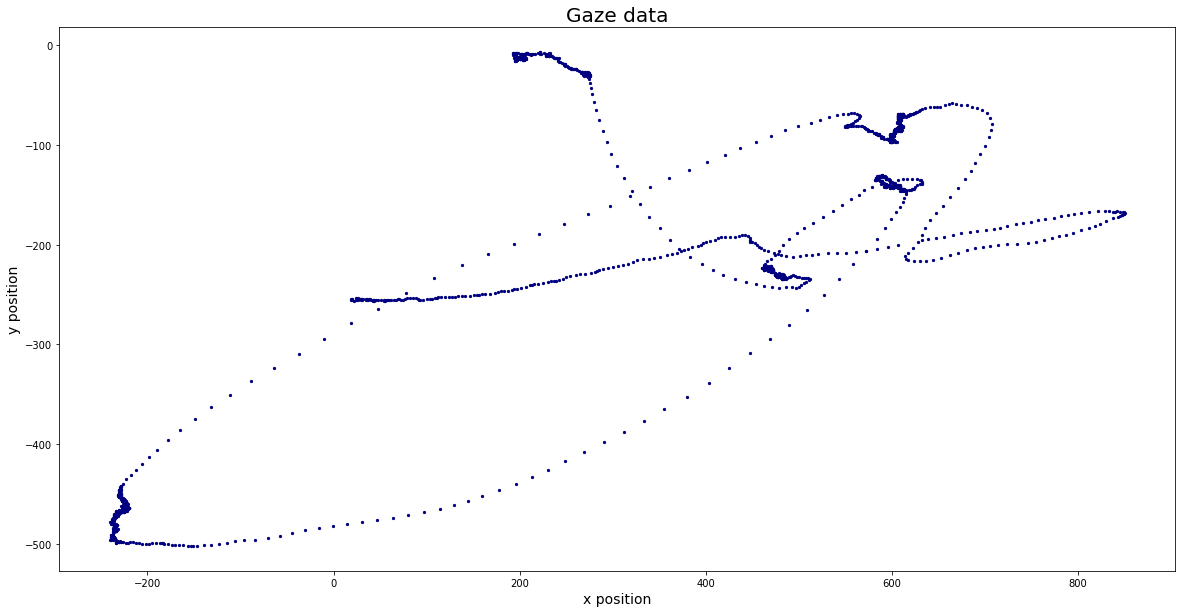

In [16]:
# Extract row and remove NaN values at the tail
row = 1
series = data.iloc[row].dropna()
# Extract every odd element (x values) and every even element (y values),
# skipping the first two elements (subject id and known fields)
x_data = series[3::2]
y_data = series[2::2]

plot_gaze((x_data, y_data))

# Data set filetring and querying
This section is used for extracting information about the subjects of interest from the dataset dataframe.

In [17]:
# List with subjects of interest
subjects = ["s3", "s5", "s9", "s11", "s17", "s23", "s25", "s31"]
# Get only data records containing subjects of interest in data 
subj_data = data[data.Subject.isin(subjects)]
# Group data by subjects
subj_data = subj_data.groupby(subj_data.Subject)
# Get records from a random subject (s3)
subj = subj_data.get_group("s3").reset_index(drop=True)
subj

,Subject,Known,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,43986,43987,43988,43989,43990,43991,43992,43993,43994,43995,43996,43997,43998,43999,44000,44001,44002,44003,44004,44005,44006,44007,44008,44009,44010,44011,44012,44013,44014,44015,44016,44017,44018,44019,44020,44021,44022,44023,44024,44025
0,s3,True,654.49,798.97,655.24,798.97,655.24,797.70,654.49,797.70,652.99,798.97,652.24,797.70,652.99,798.97,652.99,801.51,651.49,801.51,650.74,800.24,652.24,800.24,653.74,800.24,652.24,800.24,649.99,801.51,649.24,804.05,651.49,806.60,652.99,807.87,653.74,809.14,655.24,809.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,s3,False,-644.27,-746.11,-645.12,-747.45,-645.12,-748.80,-644.27,-747.45,-644.27,-744.77,-644.27,-744.77,-644.27,-746.11,-642.57,-750.14,-641.72,-751.48,-642.57,-751.48,-642.57,-751.48,-640.87,-748.80,-640.87,-747.45,-643.42,-748.80,-644.27,-748.80,-643.42,-750.14,-642.57,-748.80,-644.27,-748.80,-645.97,-747.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,s3,False,-677.86,58.87,-676.15,60.21,-676.15,64.23,-677.86,66.92,-679.56,66.92,-678.71,68.26,-677.00,66.92,-677.00,64.23,-677.86,62.89,-678.71,64.23,-679.56,65.57,-680.41,66.92,-679.56,66.92,-679.56,64.23,-681.26,61.55,-681.26,61.55,-681.26,61.55,-681.26,62.89,-681.26,64.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,s3,True,-805.96,-645.66,-806.81,-645.66,-809.36,-642.98,-811.06,-638.95,-811.91,-638.95,-811.91,-640.29,-810.21,-640.29,-809.36,-640.29,-810.21,-638.95,-811.06,-638.95,-811.91,-636.27,-812.76,-636.27,-812.76,-636.27,-812.76,-636.27,-811.91,-636.27,-812.76,-636.27,-814.46,-634.93,-814.46,-629.56,-813.61,-626.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,s3,True,736.94,84.19,737.79,82.85,737.79,81.50,736.94,80.16,735.24,81.50,733.54,82.85,732.69,82.85,734.39,84.19,734.39,84.19,732.69,84.19,731.84,82.85,732.69,81.50,733.54,81.50,731.84,81.50,731.84,82.85,734.39,84.19,735.24,85.53,734.39,84.19,732.69,82.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,s3,False,-696.44,-856.80,-697.29,-858.14,-699.84,-858.14,-699.84,-858.14,-698.99,-855.46,-699.84,-854.12,-700.69,-854.12,-701.55,-854.12,-700.69,-855.46,-698.99,-858.14,-698.14,-860.83,-698.99,-860.83,-700.69,-858.14,-701.55,-858.14,-702.40,-856.80,-700.69,-856.80,-700.69,-856.80,-701.55,-858.14,-701.55,-858.14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,s3,False,757.11,-655.00,757.11,-655.00,756.36,-655.00,754.11,-656.27,753.36,-655.00,753.36,-652.46,754.86,-652.46,755.61,-655.00,754.86,-656.27,754.11,-656.27,754.11,-655.00,754.11,-653.73,754.11,-655.00,753.36,-656.27,752.61,-655.00,751.86,-652.46,751.86,-648.65,752.61,-648.65,754.11,-652.46,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,s3,True,785.82,-531.06,785.82,-531.06,786.57,-529.79,786.57,-528.52,787.32,-527.24,786.57,-525.97,786.57,-527.24,786.57,-528.52,788.07,-529.79,788.82,-529.79,789.57,-527.24,790.32,-523.43,791.07,-522.16,792.57,-522.16,793.32,-522.16,791.07,-522.16,788.07,-522.16,786.57,-522.16,787.32,-523.43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Algorithms demo

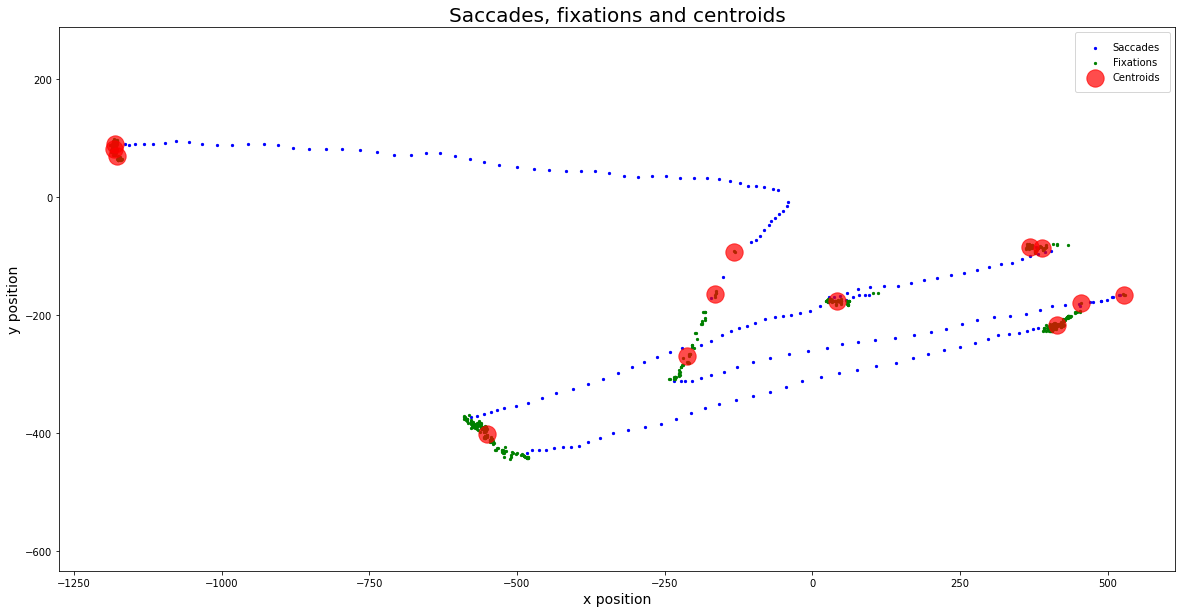

In [20]:
# Get records from a random subject
subj = subj_data.get_group("s3").reset_index(drop=True)
# Get random record from subject
subj_record = subj.iloc[2].dropna()

# Extract X and Y values from record points
x_data = list(subj_record[2::2]) # Even elements are x values
y_data = list(subj_record[3::2]) # Odd elements are y values

# Saccade threshold in pixels
thr_sacc_px = pix_from_deg(
    monitor_dims[1], subj_dist, vert_res, thr_sacc_deg
)
# Upper saccade threshold in pixels
upper_thr_sacc_px = pix_from_deg(
    monitor_dims[1], subj_dist, vert_res, upper_thr_sacc_deg
)
# Fixation threshold in pixels
thr_fix_px = pix_from_deg(
    monitor_dims[1], subj_dist, vert_res, thr_fix_deg
)

# Scale horizontal units to vertical units
x_data = [(elem*monitor_dims[0])/monitor_dims[1] for elem in x_data]

# Calculate the saccades, fixations and centroids of record using I-VT algorithm
saccades, fixations, centroids, centroid_count = I_VT_alg((x_data, y_data),
                                         sample_rate,
                                         upper_thr_sacc_px,
                                         thr_sacc_px,
                                         thr_fix_px,
                                         filt=False)

plot_simple(saccades, fixations, centroids)

### If the Velocity data is filtered:

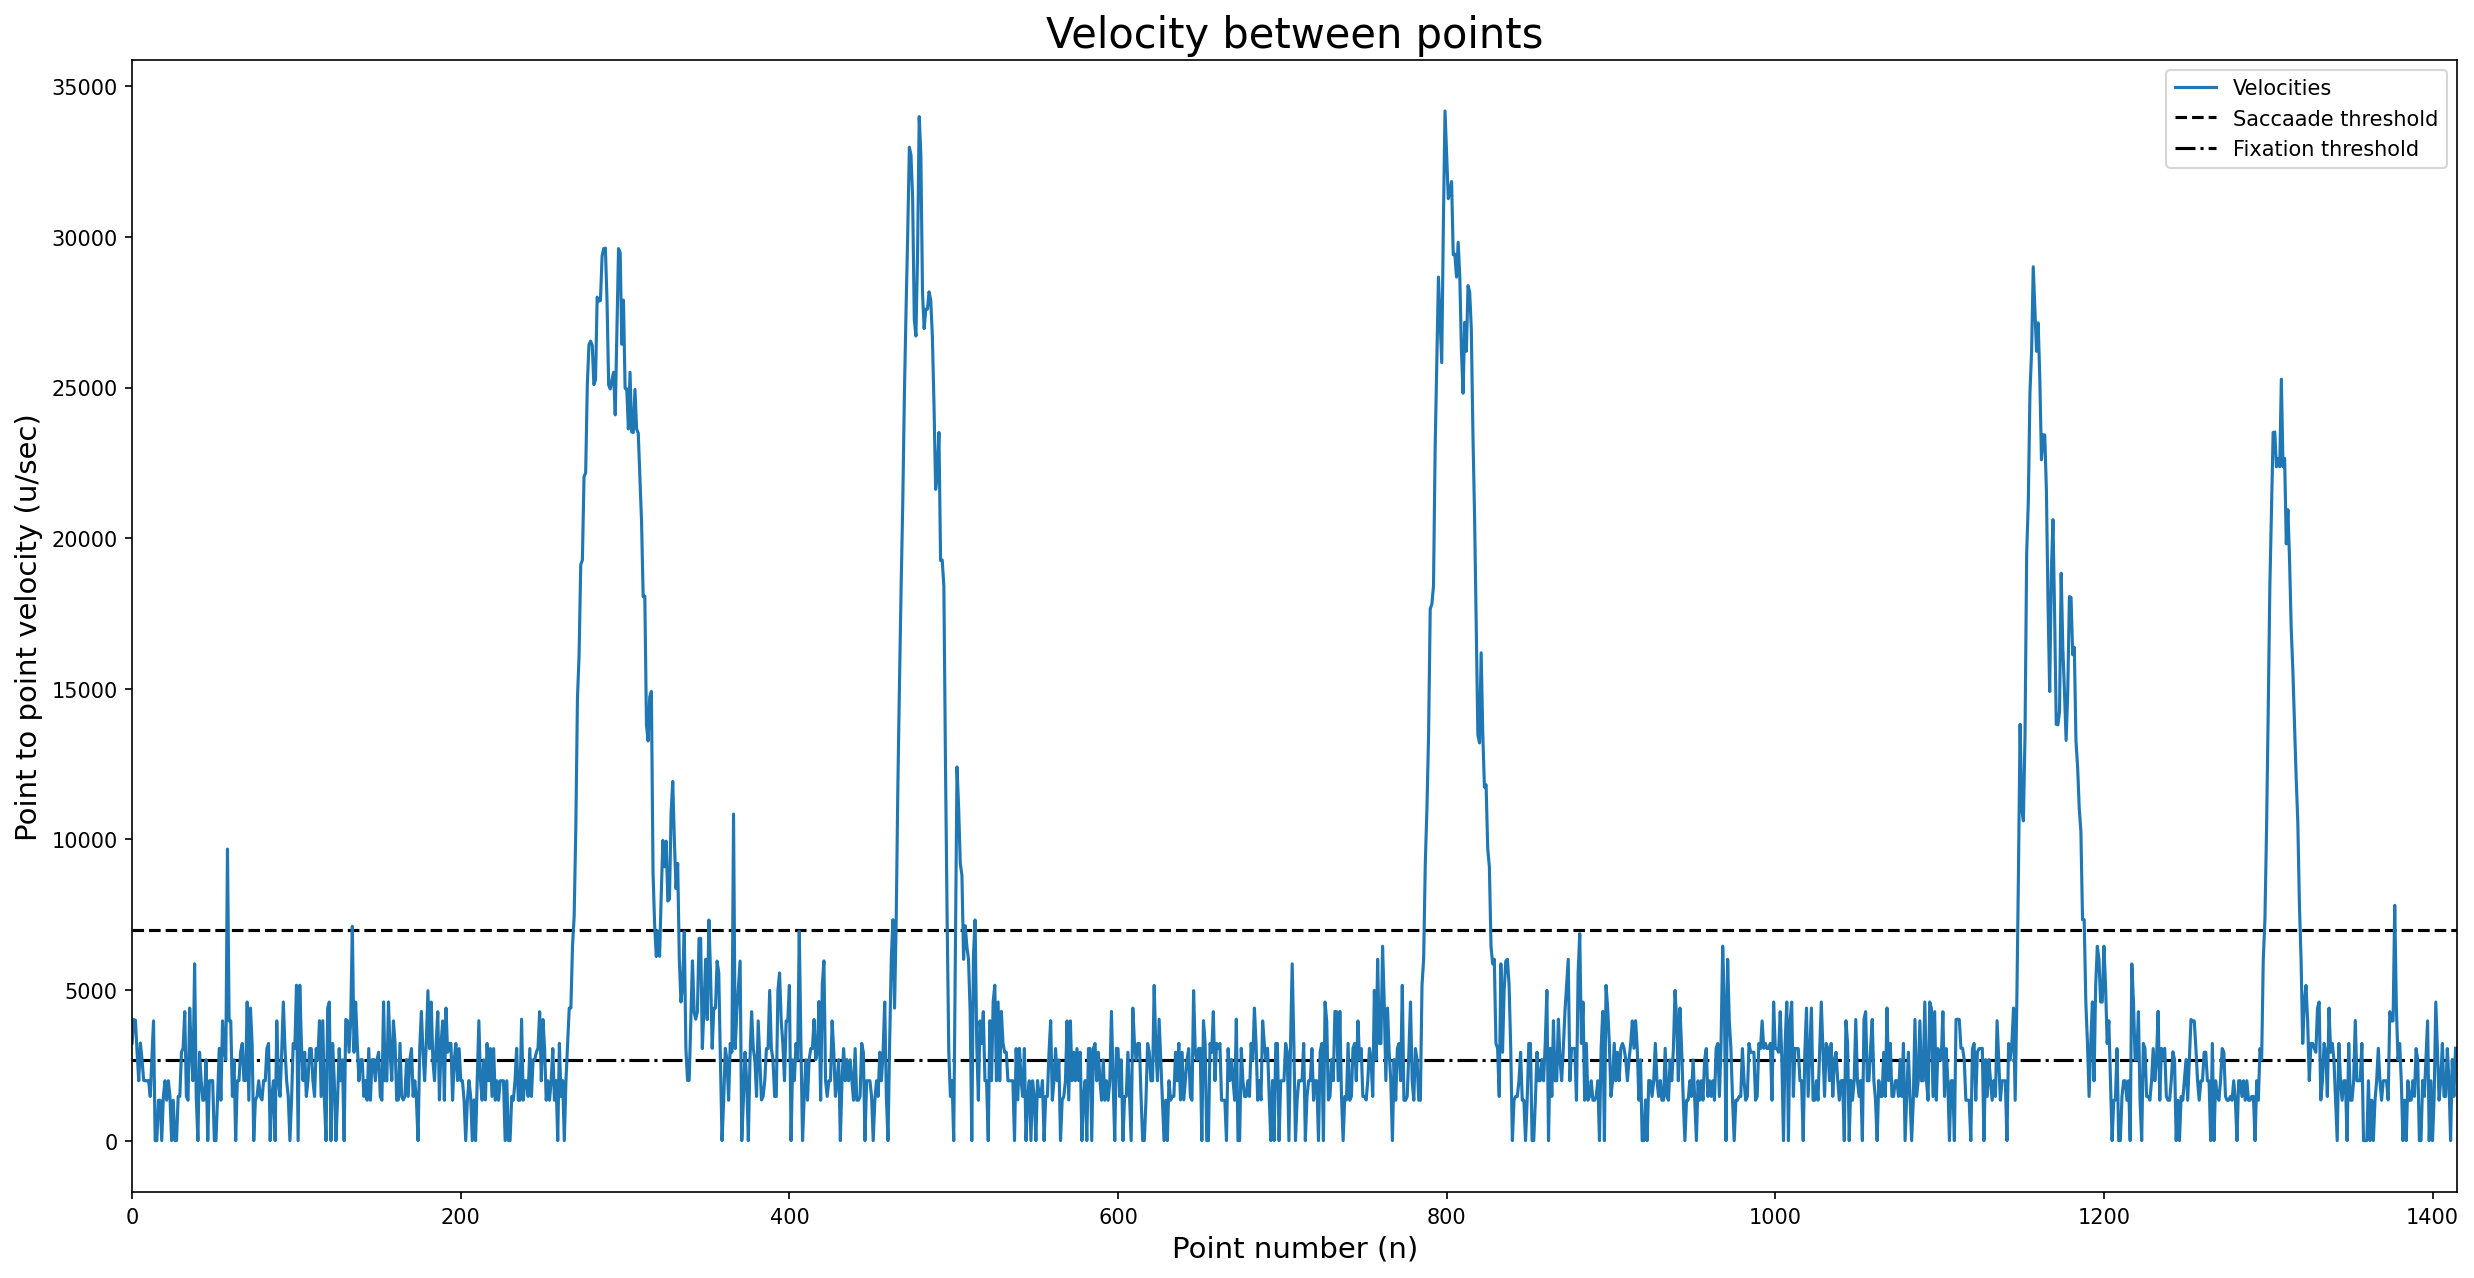

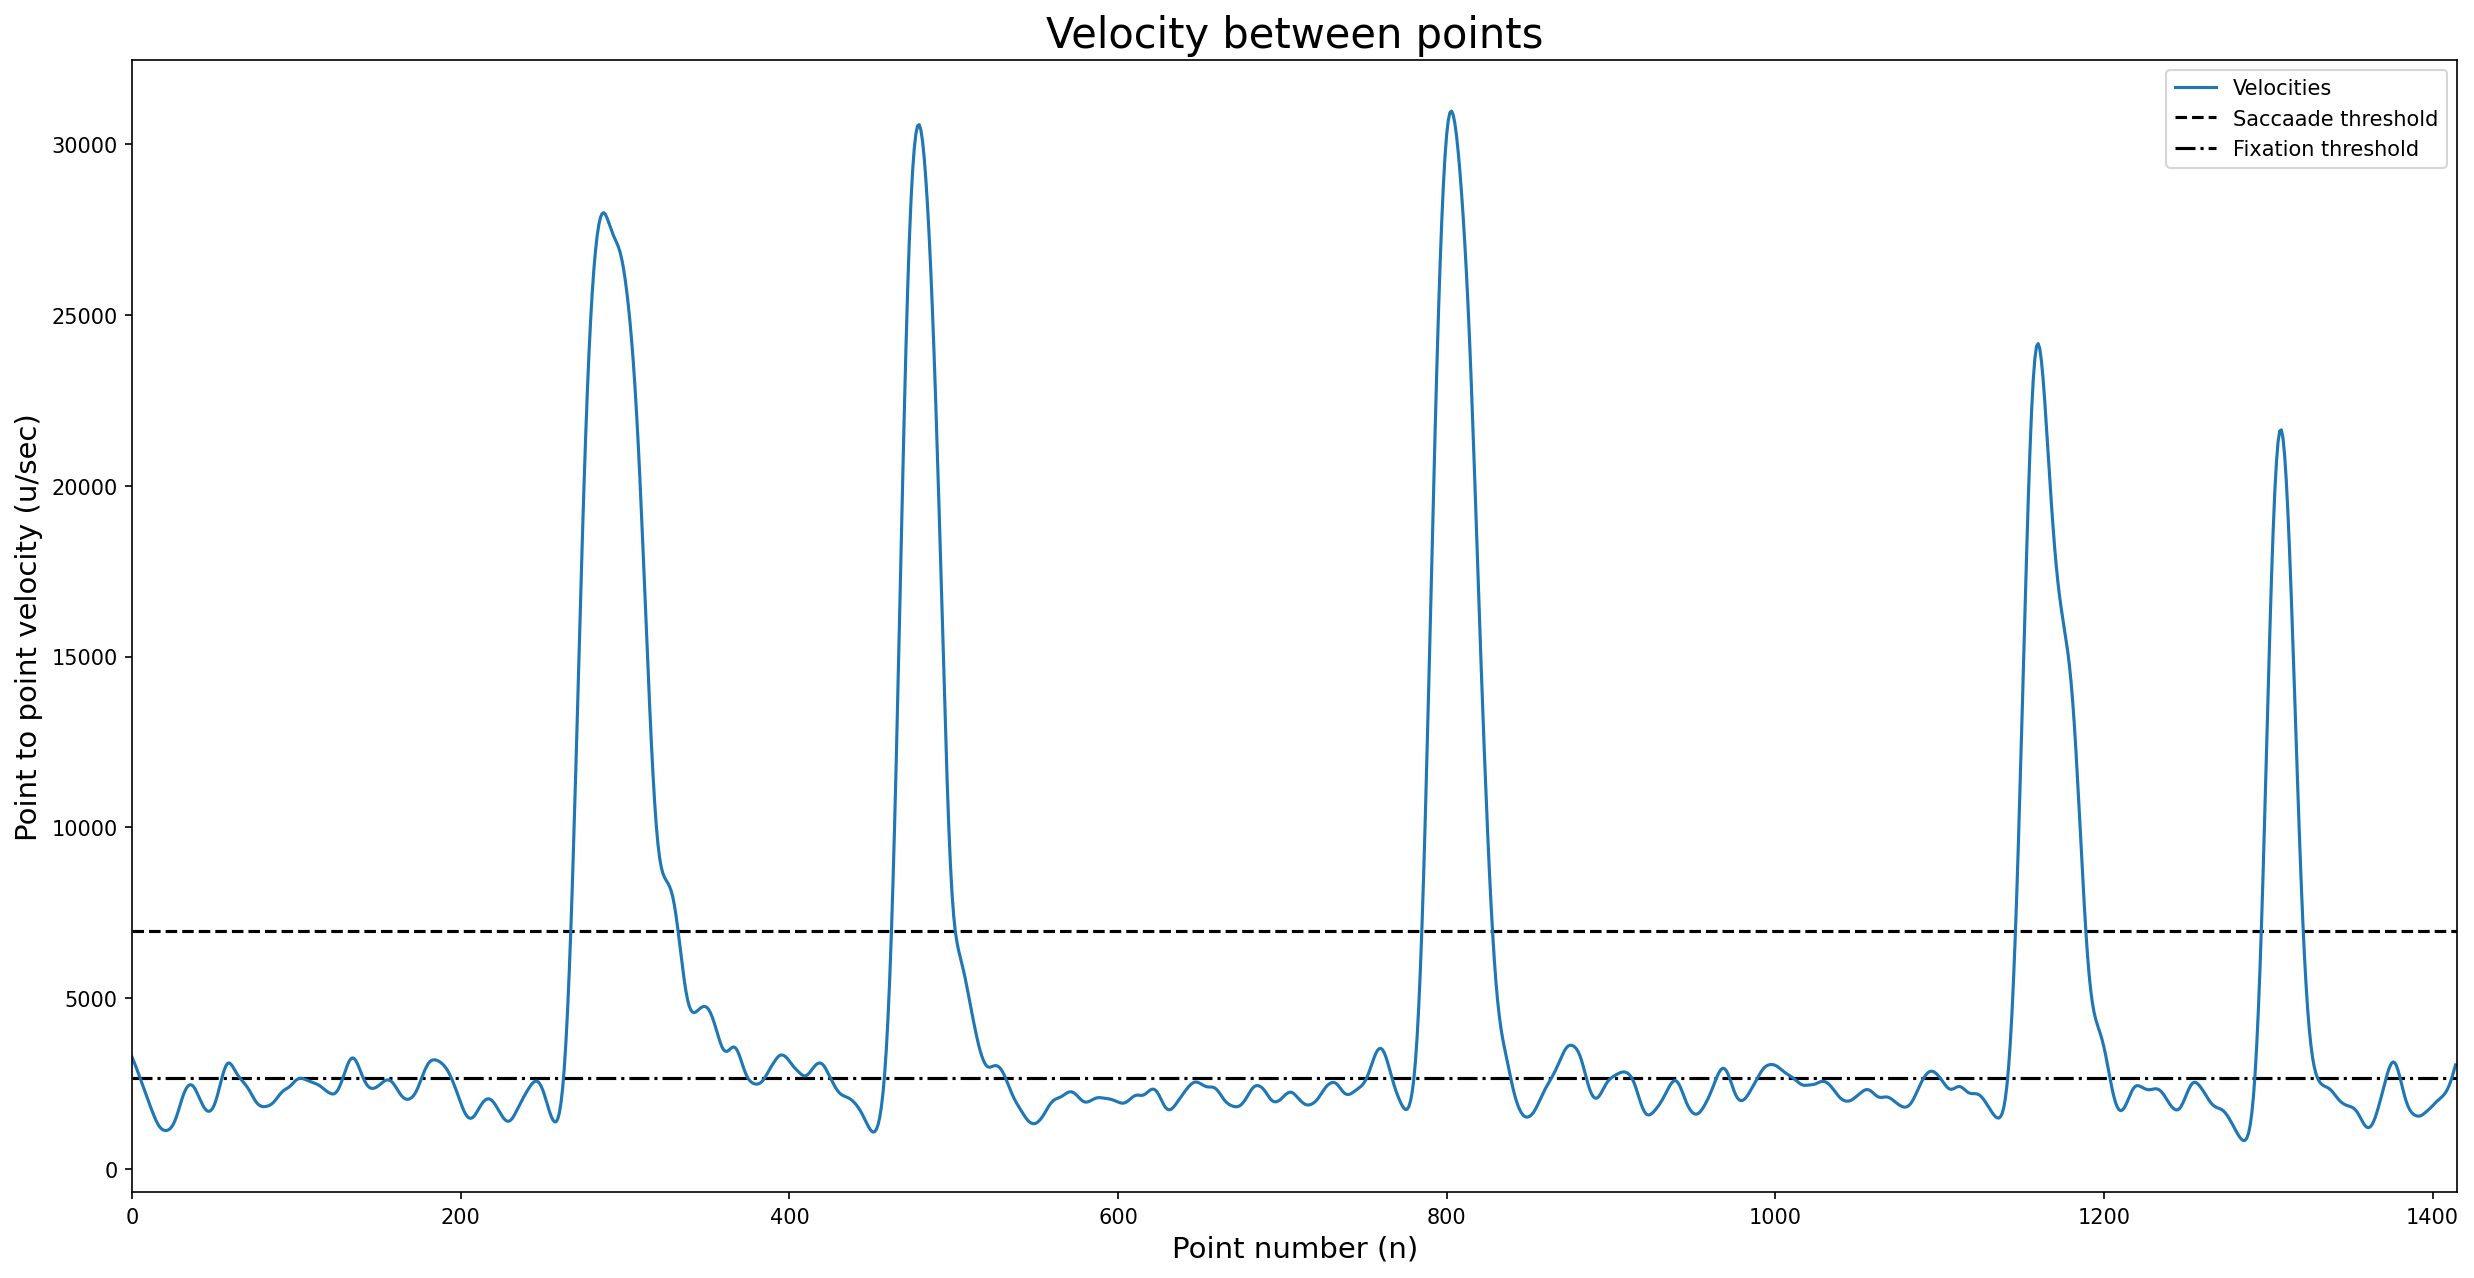

In [ ]:
vels = get_vels((x_data, y_data), sample_rate)

# Filter the data, and plot both the original and filtered signals.
filt_vels = butter_lowpass_filter(vels)

plot_vels(vels, thr_sacc_px, thr_fix_px)
plot_vels(filt_vels, thr_sacc_px, thr_fix_px)

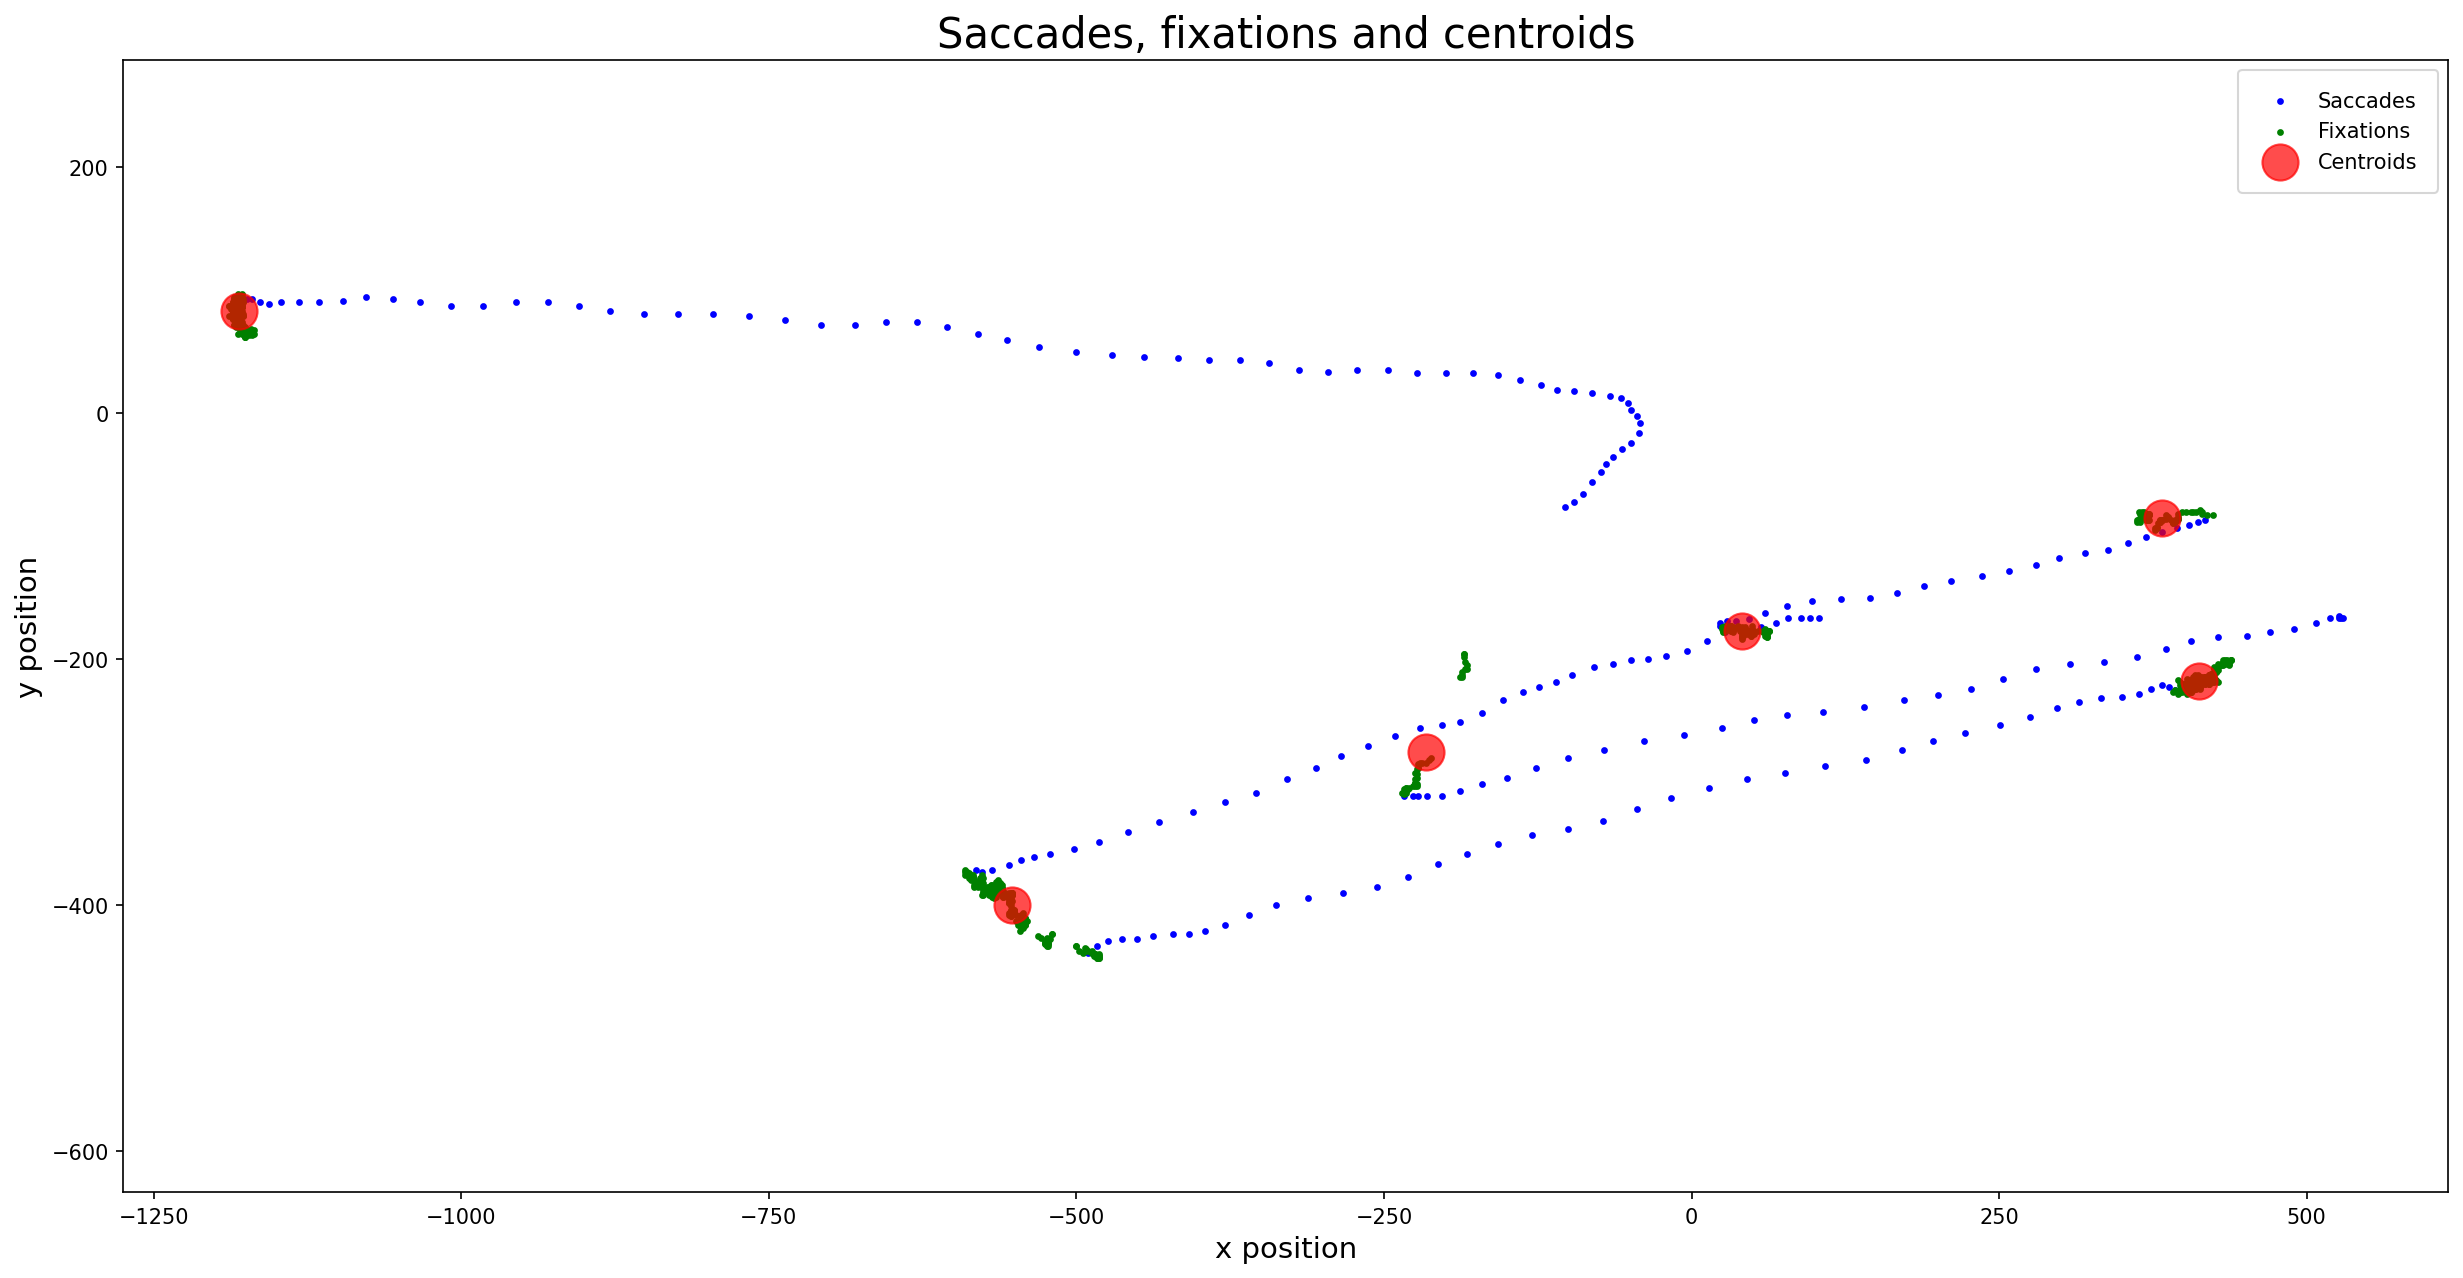

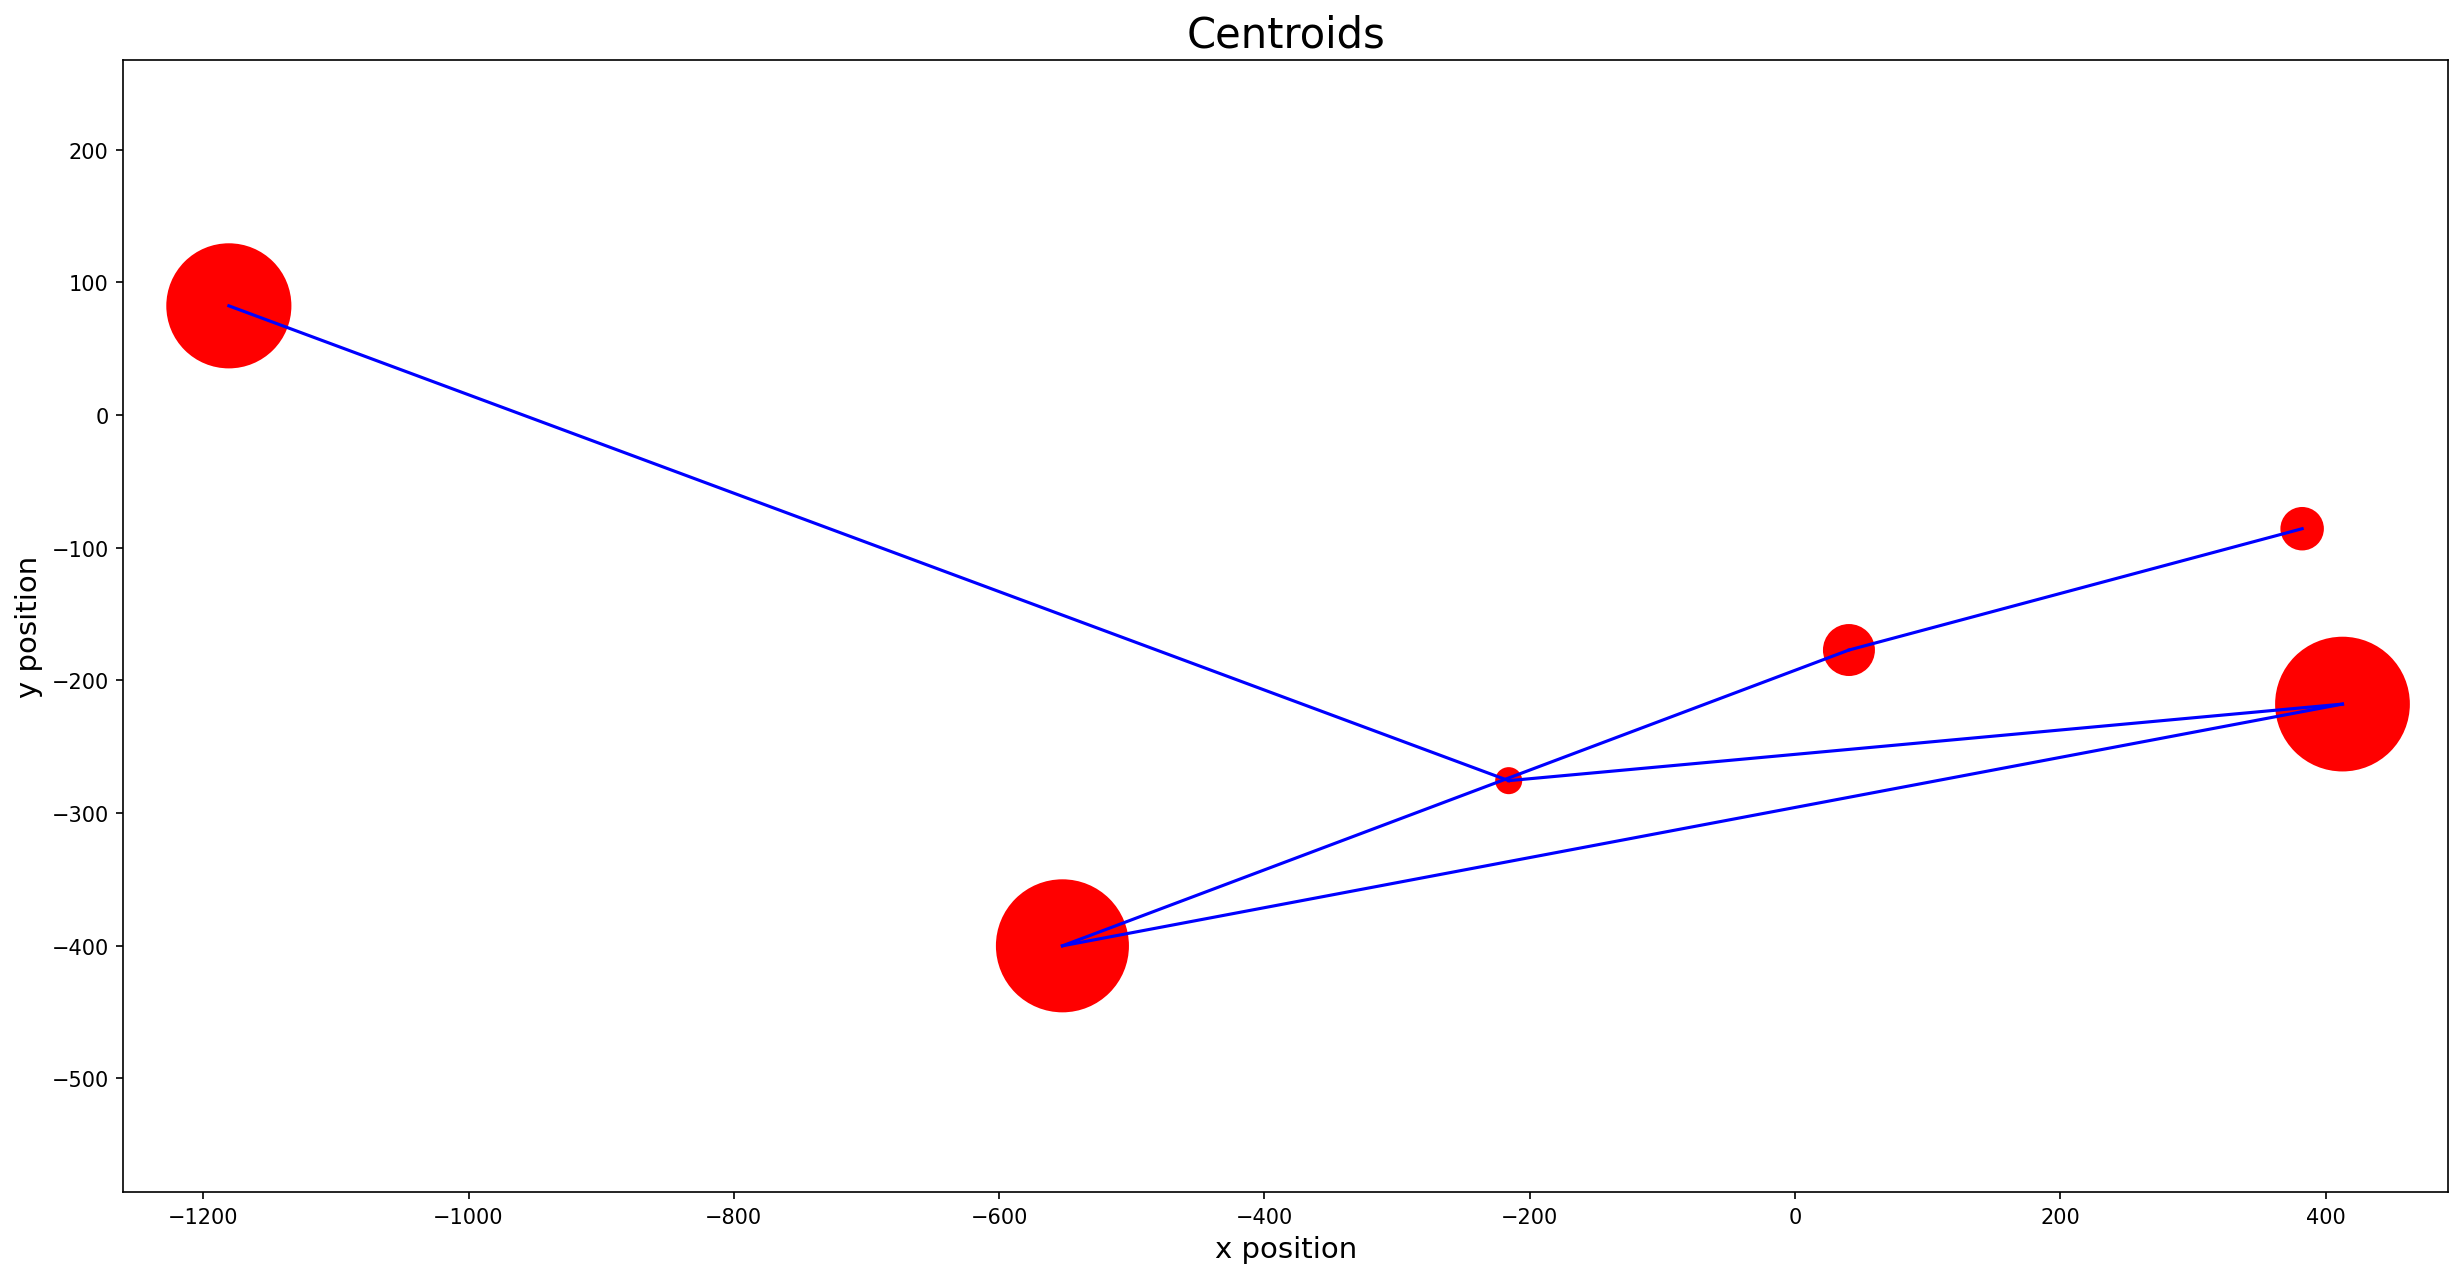

In [ ]:
saccades, fixations, centroids, centroid_count = I_VT_alg((x_data, y_data),
                                         sample_rate,
                                         upper_thr_sacc_px,
                                         thr_sacc_px,
                                         thr_fix_px,
                                         filt=True)

plot_simple(saccades, fixations, centroids)
plot_centroids(centroids, centroid_count)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


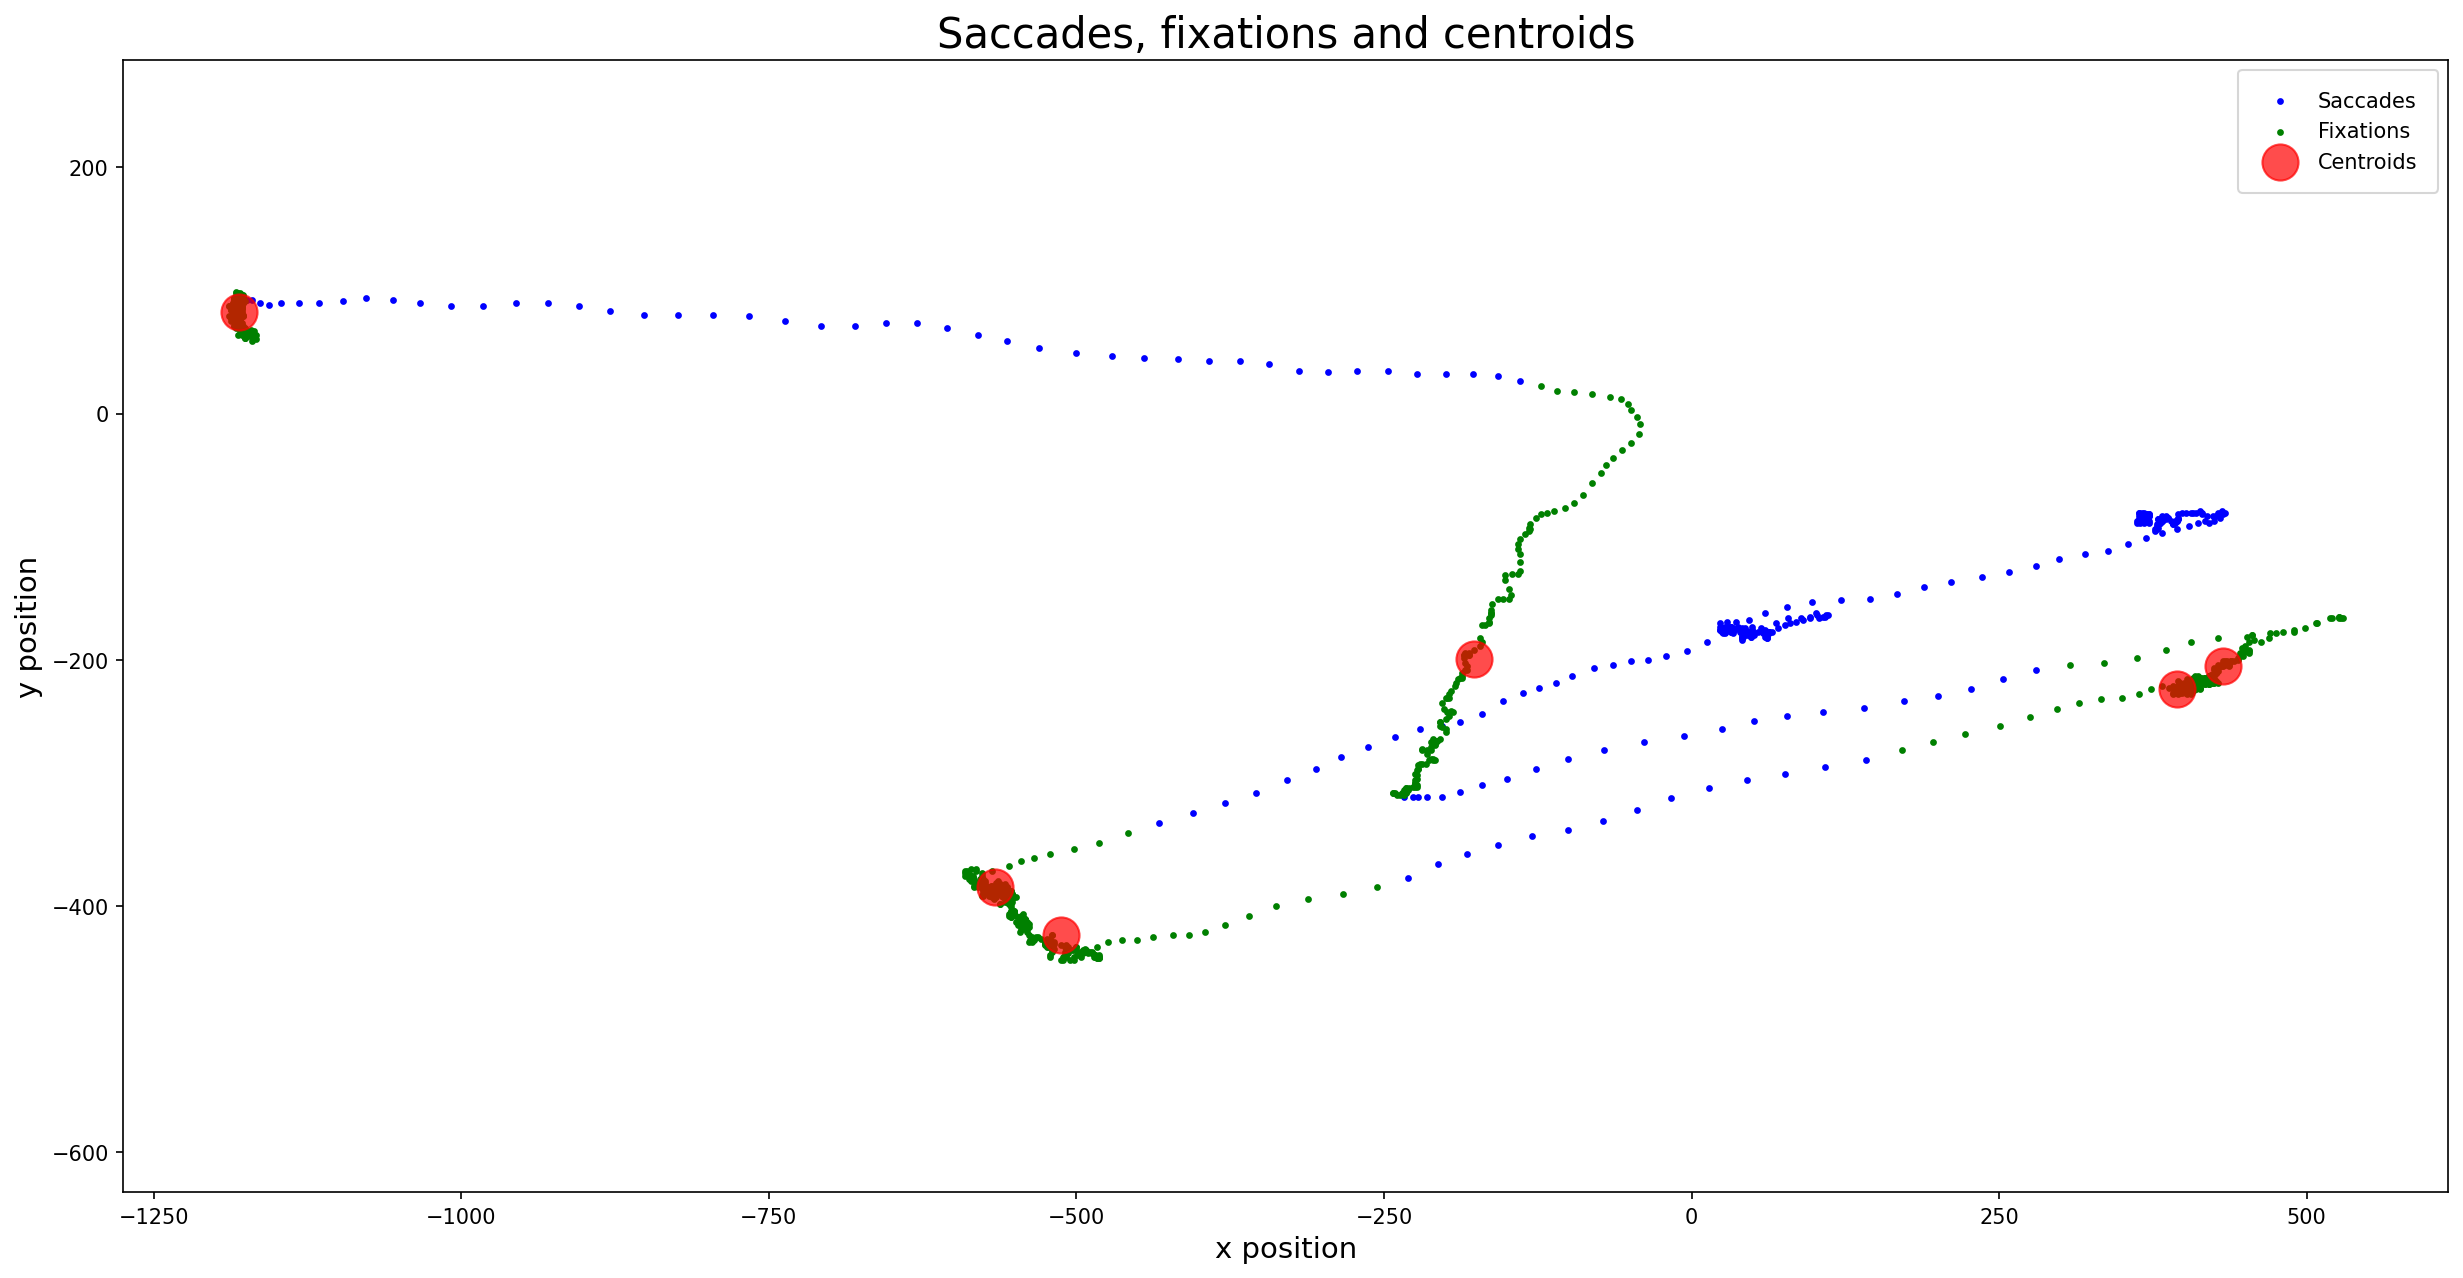

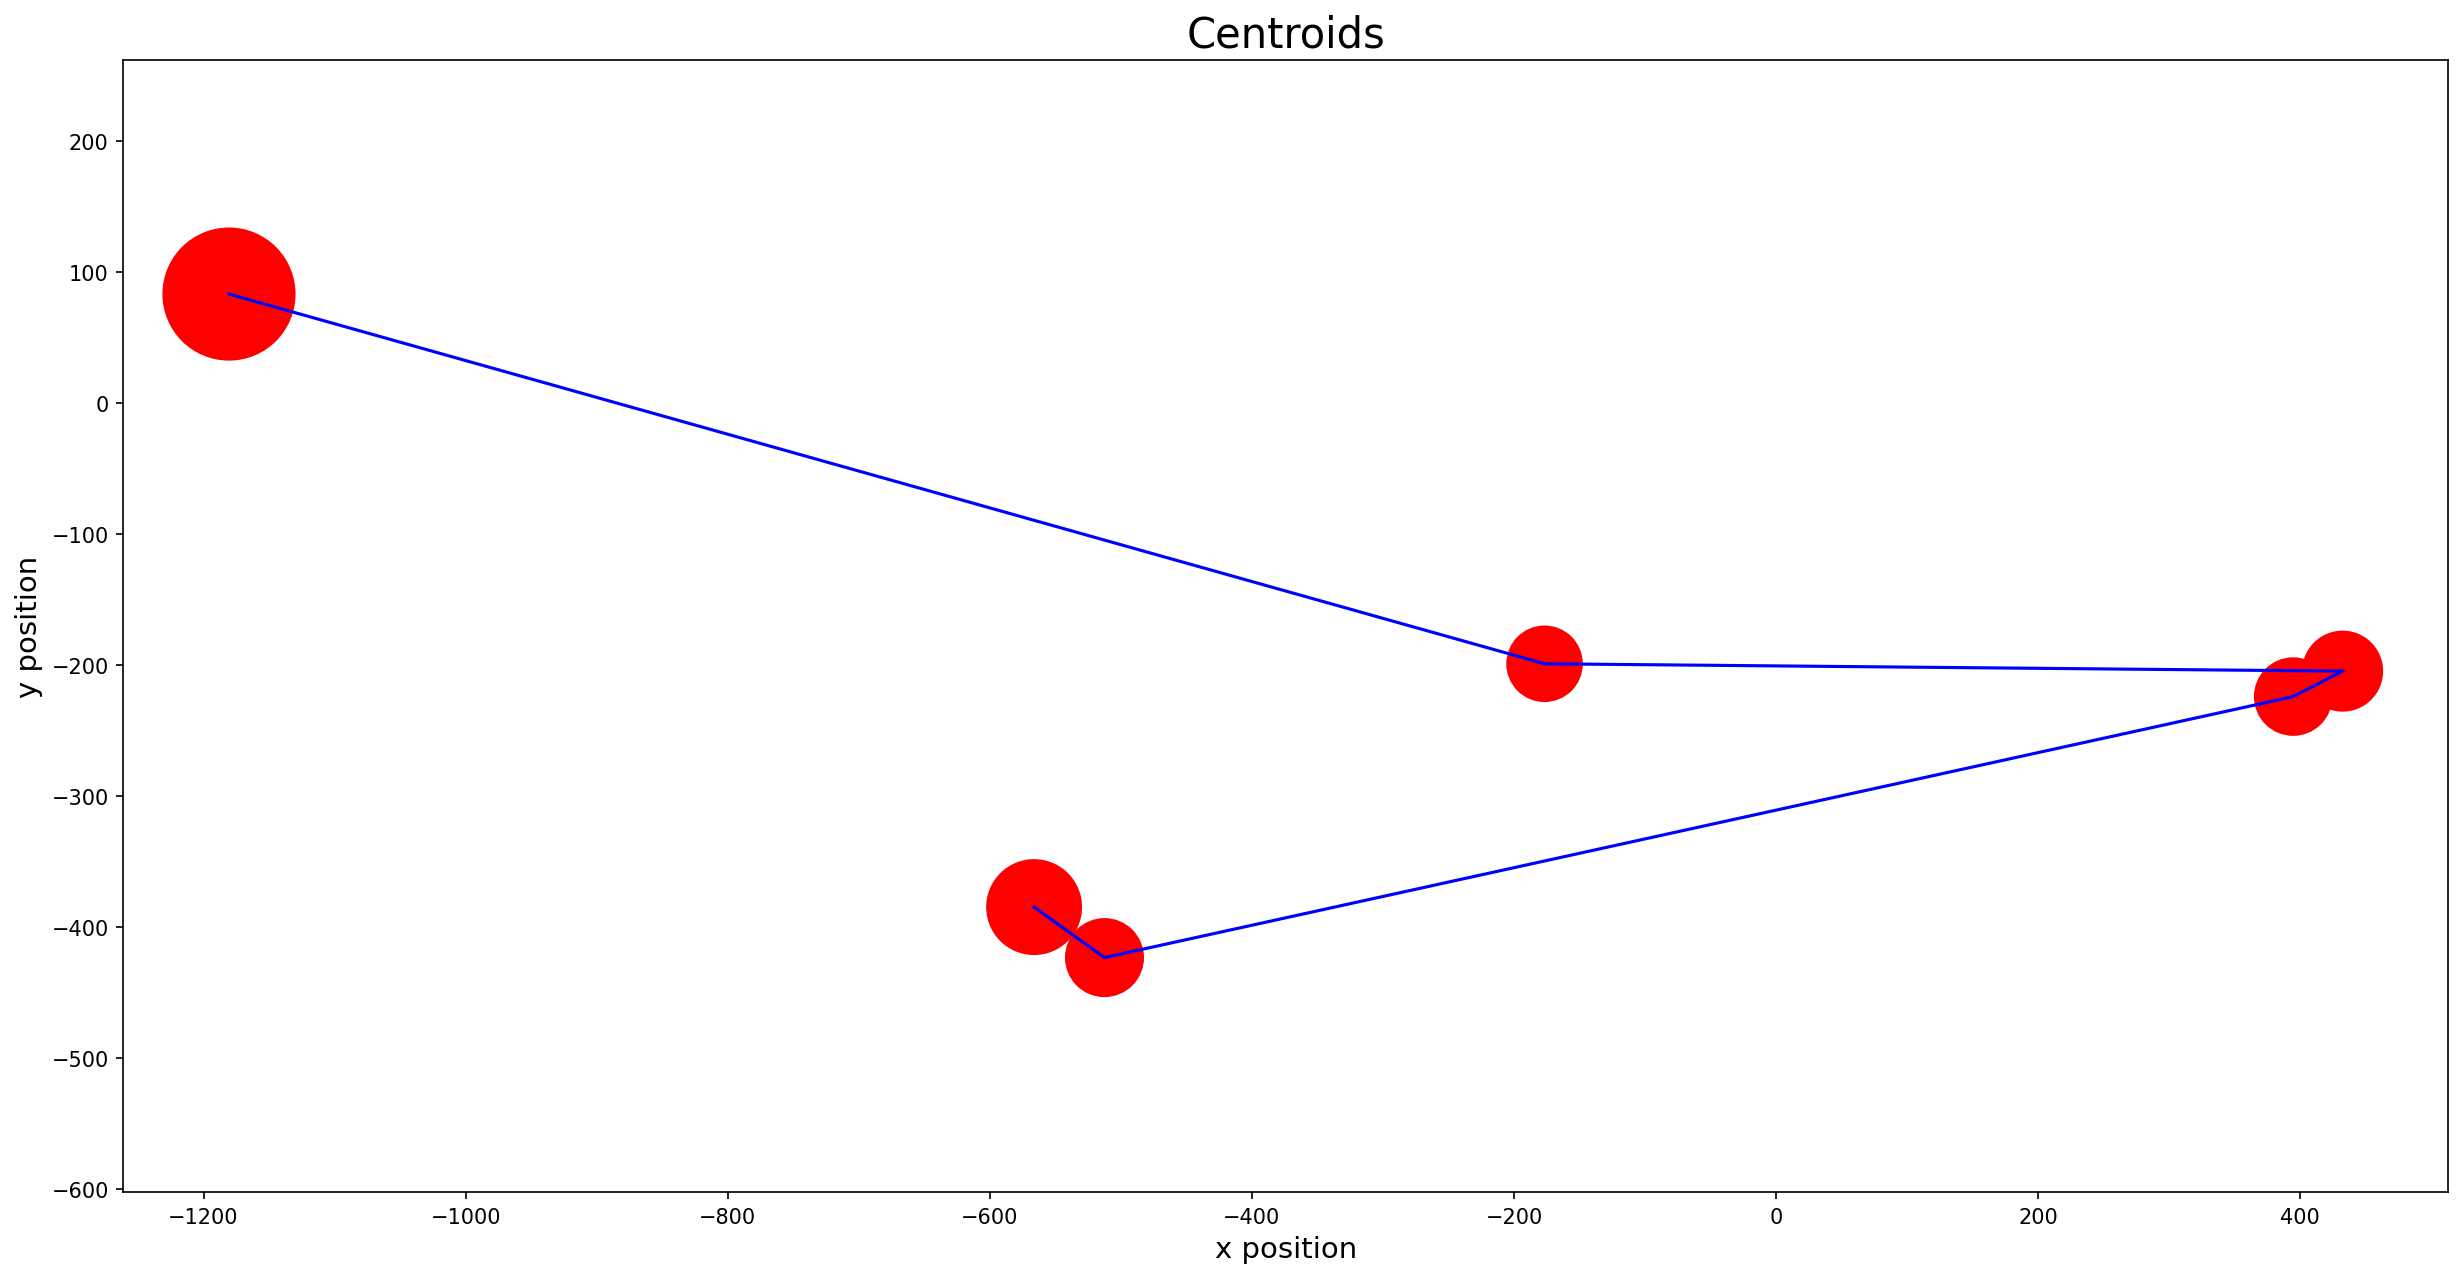

In [ ]:
disp_thrs = 600
min_count = 150
saccades, fixations, centroids, centroid_count = I_DT_alg((x_data, y_data),
                                         disp_thrs,
                                         min_count)

plot_simple(saccades, fixations, centroids)
plot_centroids(centroids, centroid_count)

# Interactive section

In [ ]:
from ipywidgets import interact, interact_manual

subjects = ["s3", "s5", "s9", "s11", "s17", "s23", "s25", "s31"]

@interact
def get_subj(Algorithm=["I_VT", "I_DT"], 
             Subject=subjects):
    subj_recs = subj_data.get_group(Subject).reset_index(drop=True)
    recs = range(len(subj_recs.index))
    @interact
    def get_rec(Record=recs):
        # print(subj_recs)
        record = subj_recs.iloc[Record].dropna()
        # Extract X and Y values from record points
        x_data = list(record[2::2]) # Even elements are x values
        y_data = list(record[3::2]) # Odd elements are y values
        # Scale horizontal units to vertical units
        x_data = [(elem*monitor_dims[0])/monitor_dims[1] for elem in x_data]    
        if Algorithm == "I_VT":
            @interact
            def get_I_VT(Saccade_Threshold=(100, 600, 10),
                         Fixation_Threshold=(100, 300, 10),
                         Filter=True):
                # Saccade threshold in pixels
                thr_sacc_px = pix_from_deg(
                    monitor_dims[1], subj_dist, vert_res, Saccade_Threshold
                )
                # Fixation threshold in pixels
                thr_fix_px = pix_from_deg(
                    monitor_dims[1], subj_dist, vert_res, Fixation_Threshold
                )
                saccades, fixations, centroids, centroid_count = I_VT_alg((x_data, y_data),
                                                sample_rate,
                                                upper_thr_sacc_px,
                                                thr_sacc_px,
                                                thr_fix_px,
                                                filt=Filter)
                @interact
                def select_plot(Plot=["Data",
                                    "Fixations",
                                    "Velocities",
                                    "Centroids"]):
                    if Plot == "Data":
                        plot_gaze((x_data, y_data))
                    elif Plot == "Fixations":
                        plot_simple(saccades, fixations, centroids)
                    elif Plot == "Velocities":
                        vels = get_vels((x_data, y_data), sample_rate)
                        # Filter the data, and plot both the original and filtered signals.
                        filt_vels = butter_lowpass_filter(vels)
                        plot_vels(vels, thr_sacc_px, thr_fix_px)
                        plot_vels(filt_vels, thr_sacc_px, thr_fix_px)
                    elif Plot == "Centroids":
                        plot_centroids(centroids, centroid_count)
                    return
                return
        else:
            @interact
            def get_I_DT(Dispersion_Threshold=(10, 100, 10),
                         Min_Count=(0, 100, 5)):
                saccades, fixations, centroids, centroid_count = I_DT_alg((x_data, y_data),
                                        Dispersion_Threshold,
                                        Min_Count)
                @interact
                def select_plot(Plot=["Data",
                                    "Fixations",
                                    "Velocities",
                                    "Centroids"]):
                    if Plot == "Data":
                        plot_gaze((x_data, y_data))
                    elif Plot == "Fixations":
                        plot_simple(saccades, fixations, centroids)
                    elif Plot == "Centroids":
                        plot_centroids(centroids, centroid_count)
                    return  
                return
    return

interactive(children=(Dropdown(description='Algorithm', options=('I_VT', 'I_DT'), value='I_VT'), Dropdown(desc…

# Data Analysis

##### Following, we report for each subject the mean fixation durations (MFD) and the mean saccade amplitudes (MSA) for the known=true and for known=false. After that, we calculate the aggregated mean fixation duration for known true and false (two values) for all subjects, including the standard deviation (SD) for all measures.

A mean fixation duration (MFD) is the sum of durations of all fixations belonging to one condition (known = true or known = false) divided by the number of fixations from this condition, e.g. all fixations that belong to one subject and to one setting (e.g. known = true, or known=false, or all data).

In [ ]:
# List of subjects of interest
subjects = ["s3", "s5", "s9", "s11", "s17", "s23", "s25", "s31"]

# Initialize empty dictionary containing
# every subject data for both I-VT and I-DT
subjs_data_ivt = {}
subjs_data_idt = {}

# Initialize empty lists to calculate overall MFD
# and MSA over all the subjects for I-VT and I-DT
fix_true_overall_ivt = []
fix_false_overall_ivt = []
fix_true_overall_idt = []
fix_false_overall_idt = []

sac_true_overall_ivt = []
sac_false_overall_ivt = []
sac_true_overall_idt = []
sac_false_overall_idt = []

for subject in subjects:

  # Get records from current subject
  subj = subj_data.get_group(subject).reset_index(drop=True)

  # Initialize lists containing fixation durations and saccades
  # amplitudes for known= True, False and overall for I-VT and I-DT
  fix_true_ivt = []
  fix_false_ivt = []
  sacc_true_ivt = []
  sacc_false_ivt = []

  fix_true_idt = []
  fix_false_idt = []
  sacc_true_idt = []
  sacc_false_idt = []

  for session in range(len(subj)):

    # Get random record from subject
    subj_record = subj.iloc[session].dropna()

    # Extract X and Y values from record points
    x_data = list(subj_record[2::2]) # Even elements are x values
    y_data = list(subj_record[3::2]) # Odd elements are y values

    # Convert saccade threshold to pixel/s
    thr_sacc_px = pix_from_deg(
        monitor_dims[1], subj_dist, vert_res, thr_sacc_deg
    )

    # Convert fixation threshold to pixel/s
    thr_fix_px = pix_from_deg(
        monitor_dims[1], subj_dist, vert_res, thr_fix_deg
    )

    # Scale horizontal units to vertical units
    x_data = [(elem*monitor_dims[0])/monitor_dims[1] for elem in x_data]

    # Calculate the saccades, fixations using I-VT algorithm
    saccades_ivt, fixations_ivt, _, _ = I_VT_alg((x_data, y_data),
                                          sample_rate,
                                          upper_thr_sacc_px,
                                          thr_sacc_px,
                                          thr_fix_px,
                                          True)
    # Calculate the saccades, fixations using I-DT algorithm
    saccades_idt, fixations_idt, _, _ = I_DT_alg((x_data, y_data),
                                         disp_thrs,
                                         min_count)
     
    # Calculate fixation duration using I-VT
    for fix_gr in fixations_ivt:

      # Calculate fixation duration in millisecond
      duration = len(fix_gr)/sample_rate * 1000

      # Filter fixations shorter than 75 ms
      if duration >= thr_fix_dur:
      
        # Check if Known = False or True
        if (subj_record.Known):
          # Append fixation duration to list of fixations
          # for known = True
          fix_true_ivt.append(duration)

          # Append duration to overall fixation list
          fix_true_overall_ivt.append(duration)
          
        else:
          # Append fixation duration to list of fixations
          # for known = False
          fix_false_ivt.append(duration)

          # Append duration to overall fixation list
          fix_false_overall_ivt.append(duration)

    # Calculate saccade amplitude using I-VT
    for sacc_gr in saccades_ivt:

      # Calculate saccade amplitude
      amplitude = deg_from_pix(monitor_dims[1], subj_dist, vert_res,
                               sqrt(((sacc_gr[-1][0] - sacc_gr[0][0]) ** 2 + (sacc_gr[-1][1] - sacc_gr[0][1]) ** 2)))
      
      # Check if Known = False or True
      if (subj_record.Known):
        # Append fixation duration to list of fixations
        # for known = True
        sacc_true_ivt.append(amplitude)

        # Append amplitude to overall saccade list
        sac_true_overall_ivt.append(amplitude)

      else:
        # Append fixation duration to list of fixations
        # for known = False
        sacc_false_ivt.append(amplitude)

        # Append amplitude to overall saccade list
        sac_false_overall_ivt.append(amplitude)
    
    # Calculate fixation duration using I-DT
    for fix_gr in fixations_idt:

      # Calculate fixation duration in millisecond
      duration = len(fix_gr)/sample_rate * 1000
      
      # Filter fixations shorter than 75 ms
      if duration >= thr_fix_dur:

        # Check if Known = False or True
        if (subj_record.Known):
          # Append fixation duration to list of fixations
          # for known = True
          fix_true_idt.append(duration)

          # Append duration to overall fixation list
          fix_true_overall_idt.append(duration)
          
        else:
          # Append fixation duration to list of fixations
          # for known = False
          fix_false_idt.append(duration)

          # Append duration to overall fixation list
          fix_false_overall_idt.append(duration)
    
    # Calculate saccade amplitude using I-DT
    for sacc_gr in saccades_idt:

      # Calculate saccade amplitude
      amplitude = deg_from_pix(monitor_dims[1], subj_dist, vert_res,
                               sqrt(((sacc_gr[-1][0] - sacc_gr[0][0]) ** 2 + (sacc_gr[-1][1] - sacc_gr[0][1]) ** 2)))
      
      # Check if Known = False or True
      if (subj_record.Known):
        # Append fixation duration to list of fixations
        # for known = True
        sacc_true_idt.append(amplitude)

        # Append amplitude to overall saccade list
        sac_true_overall_idt.append(amplitude)

      else:
        # Append fixation duration to list of fixations
        # for known = False
        sacc_false_idt.append(amplitude)

        # Append amplitude to overall saccade list
        sac_false_overall_idt.append(amplitude)

  # Calculate mean fixation duration and
  # standard deviation for current subject
  # separating known = true from false for I-VT
  mfd_true_ivt = np.mean(fix_true_ivt)
  mfd_sd_true_ivt = np.std(fix_true_ivt)
  mfd_false_ivt = np.mean(fix_false_ivt)
  mfd_sd_false_ivt = np.std(fix_false_ivt)

  # Calculate mean saccade amplitude and
  # standard deviation for current subject
  # separating known = true from false for I-DT 
  msa_true_ivt = np.mean(sacc_true_ivt)
  msa_sd_true_ivt = np.std(sacc_true_ivt)
  msa_false_ivt = np.mean(sacc_false_ivt)
  msa_sd_false_ivt = np.std(sacc_false_ivt)

  # Calculate mean fixation duration and
  # standard deviation for current subject
  # separating known = true from false for I-DT
  mfd_true_idt = np.mean(fix_true_idt)
  mfd_sd_true_idt = np.std(fix_true_idt)
  mfd_false_idt = np.mean(fix_false_idt)
  mfd_sd_false_idt = np.std(fix_false_idt)

  # Calculate mean saccade amplitude and
  # standard deviation for current subject
  # separating known = true from false for I-DT 
  msa_true_idt = np.mean(sacc_true_idt)
  msa_sd_true_idt = np.std(sacc_true_idt)
  msa_false_idt = np.mean(sacc_false_idt)
  msa_sd_false_idt = np.std(sacc_false_idt)

  # Store I-VT values in dictionary
  subjs_data_ivt[subject] = {'mfd_true': mfd_true_ivt,
                         'mfd_sd_true' : mfd_sd_true_ivt,
                         'mfd_false' : mfd_false_ivt,
                         'mfd_sd_false' : mfd_sd_false_ivt,
                         'msa_true': msa_true_ivt,
                         'msa_sd_true' : msa_sd_true_ivt,
                         'msa_false' : msa_false_ivt,
                         'msa_sd_false' : msa_sd_false_ivt}

  # Store I-DT values in dictionary
  subjs_data_idt[subject] = {'mfd_true': mfd_true_idt,
                         'mfd_sd_true' : mfd_sd_true_idt,
                         'mfd_false' : mfd_false_idt,
                         'mfd_sd_false' : mfd_sd_false_idt,
                         'msa_true': msa_true_idt,
                         'msa_sd_true' : msa_sd_true_idt,
                         'msa_false' : msa_false_idt,
                         'msa_sd_false' : msa_sd_false_idt}

# Calculate the aggregated mean fixation duration
# for known true and false for all subjects using I-VT
mfd_overall_true_ivt = np.mean(fix_true_overall_ivt)
mfd_overall_false_ivt = np.mean(fix_false_overall_ivt)

mfd_overall_true_SD_ivt = np.std(fix_true_overall_ivt)
mfd_overall_false_SD_ivt = np.std(fix_false_overall_ivt)

# Calculate the aggregated mean fixation duration
# for known true and false for all subjects using I-DT
mfd_overall_true_idt = np.mean(fix_true_overall_idt)
mfd_overall_false_idt = np.mean(fix_false_overall_idt)

mfd_overall_true_SD_idt = np.std(fix_true_overall_idt)
mfd_overall_false_SD_idt = np.std(fix_false_overall_idt)

# Calculate the aggregated mean saccade amplitude
# for known true and false for all subjects using I-VT
msa_overall_true_ivt = np.mean(sac_true_overall_ivt)
msa_overall_false_ivt = np.mean(sac_false_overall_ivt)

msa_overall_true_SD_ivt = np.std(sac_true_overall_ivt)
msa_overall_false_SD_ivt = np.std(sac_false_overall_ivt)

# Calculate the aggregated mean saccade amplitude
# for known true and false for all subjects using I-DT
msa_overall_true_idt = np.mean(sac_true_overall_idt)
msa_overall_false_idt = np.mean(sac_false_overall_idt)

msa_overall_true_SD_idt = np.std(sac_true_overall_idt)
msa_overall_false_SD_idt = np.std(sac_false_overall_idt)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


#### Create a csv file

In [ ]:
with open('/content/drive/MyDrive/group_9.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["subject_id", "MFD_true", "MFD_SD_true", "MFD_false",
                     "MFD_SD_false", "MSA_true", "MSA_SD_true", "MSA_false",
                     "MSA_SD_false", "MFD_overall", "MFD_overall_SD",
                     "MSA_overall", "MSA_overall_SD"])
    for subj in subjs_data_ivt: 
      row = [subj, subjs_data_ivt[subj]['mfd_true'], subjs_data_ivt[subj]['mfd_sd_true'],
            subjs_data_ivt[subj]['mfd_false'], subjs_data_ivt[subj]['mfd_sd_false'], 
            subjs_data_ivt[subj]['msa_true'], subjs_data_ivt[subj]['msa_sd_true'],
            subjs_data_ivt[subj]['msa_false'], subjs_data_ivt[subj]['msa_sd_false'],
            mfd_overall_true_ivt, mfd_overall_true_SD_ivt, msa_overall_true_ivt, msa_overall_true_SD_ivt]
      writer.writerow([item for item in row])


#### Plotting the data.

Use charts so that you can indicate standard deviation or standard error of the mean (SEM) as +-error bars. Important: compare the known=true and known=false conditions (for aggregated data of all your subjects), and discuss eventual differences briefly.

<Figure size 3000x1500 with 0 Axes>

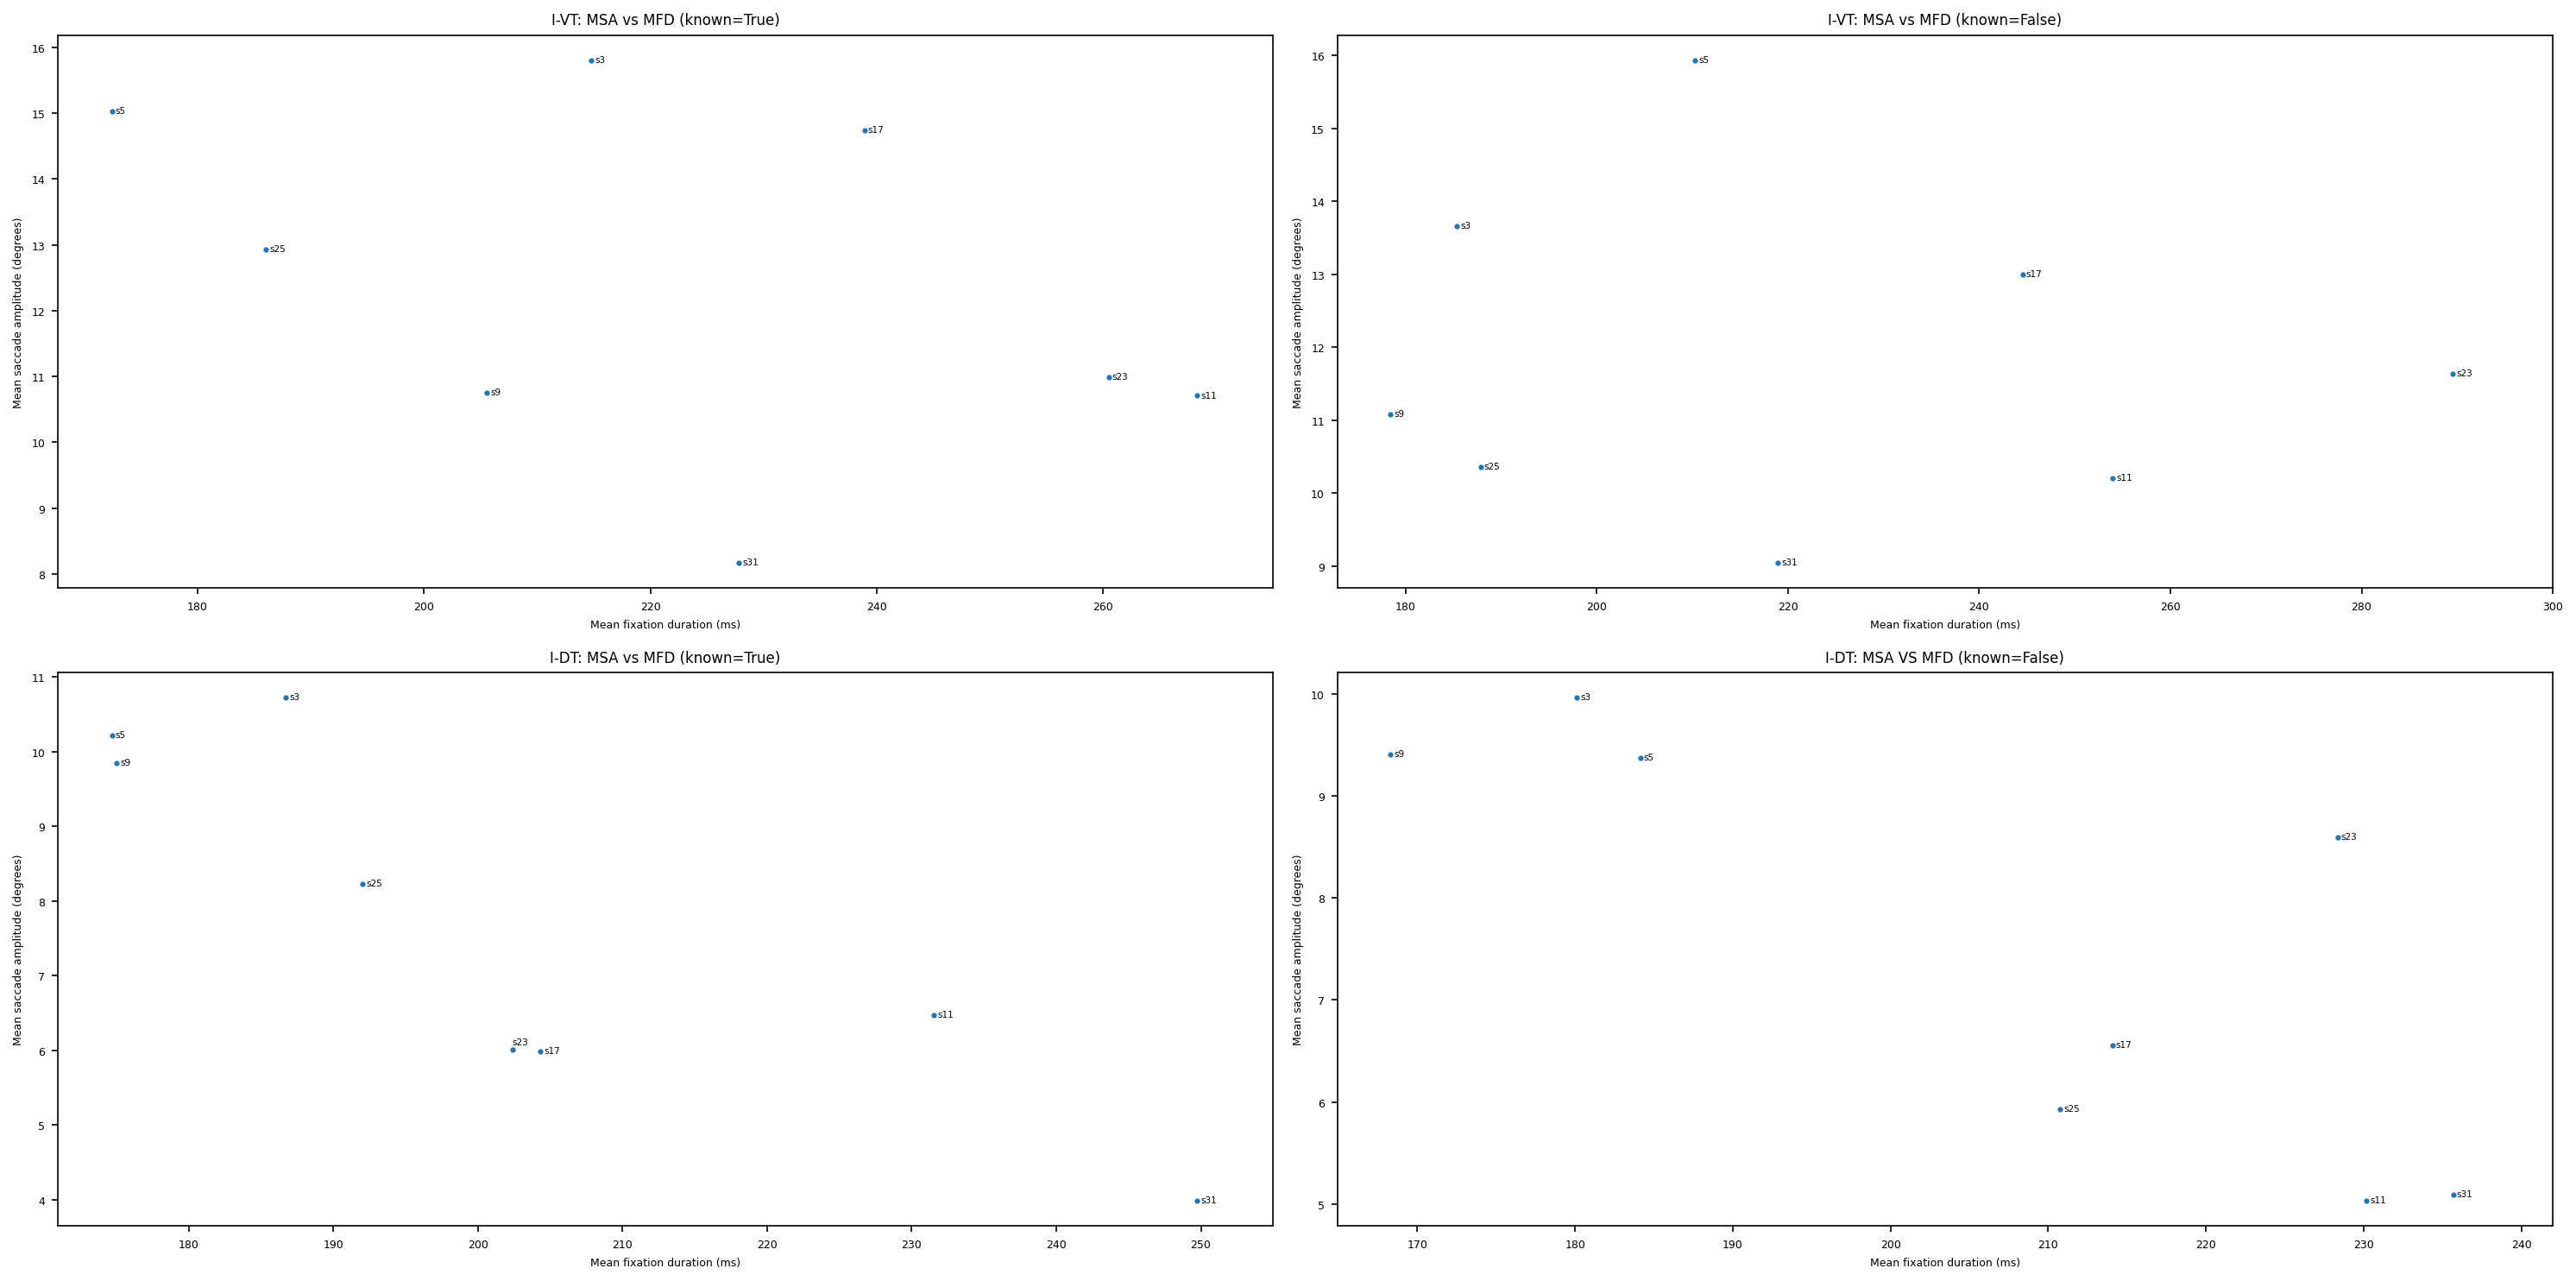

In [ ]:
mfd_true_ivt = []
mfd_sd_true_ivt = []
mfd_false_ivt =[]
mfd_sd_false_ivt = []
msa_true_ivt = []
msa_sd_true_ivt = []
msa_false_ivt = []
msa_sd_false_ivt = []

mfd_true_idt = []
mfd_sd_true_idt = []
mfd_false_idt =[]
mfd_sd_false_idt = []
msa_true_idt = []
msa_sd_true_idt = []
msa_false_idt = []
msa_sd_false_idt = []

for subj in subjs_data_ivt:
    mfd_true_ivt.append(subjs_data_ivt[subj]['mfd_true'])
    mfd_false_ivt.append(subjs_data_ivt[subj]['mfd_false'])
    msa_true_ivt.append(subjs_data_ivt[subj]['msa_true'])
    msa_false_ivt.append(subjs_data_ivt[subj]['msa_false'])
    mfd_sd_true_ivt.append(subjs_data_ivt[subj]['mfd_sd_true'])
    mfd_sd_false_ivt.append(subjs_data_ivt[subj]['mfd_sd_false'])
    msa_sd_true_ivt.append(subjs_data_ivt[subj]['msa_sd_true'])
    msa_sd_false_ivt.append(subjs_data_ivt[subj]['msa_sd_false'])

for subj in subjs_data_idt:
    mfd_true_idt.append(subjs_data_idt[subj]['mfd_true'])
    mfd_false_idt.append(subjs_data_idt[subj]['mfd_false'])
    msa_true_idt.append(subjs_data_idt[subj]['msa_true'])
    msa_false_idt.append(subjs_data_idt[subj]['msa_false'])
    mfd_sd_true_idt.append(subjs_data_idt[subj]['mfd_sd_true'])
    mfd_sd_false_idt.append(subjs_data_idt[subj]['mfd_sd_false'])
    msa_sd_true_idt.append(subjs_data_idt[subj]['msa_sd_true'])
    msa_sd_false_idt.append(subjs_data_idt[subj]['msa_sd_false'])


fig = plt.figure()
plt.rcParams['figure.dpi'] = 150

fig, axes = plt.subplots(nrows = 2, ncols = 2)

axes[0][0].scatter(mfd_true_ivt, msa_true_ivt, s=4)
axes[0][0].set_xlabel('Mean fixation duration (ms)', fontsize=6)
axes[0][0].set_ylabel('Mean saccade amplitude (degrees)', fontsize=6)
axes[0][0].set_title('I-VT: MSA vs MFD (known=True)', fontsize=8)
axes[0][0].tick_params(axis="both", labelsize=6)
axes[0][0].set_xlim(xmax=275)
for idx, subject in enumerate(subjects):
    axes[0][0].annotate(subject, (mfd_true_ivt[idx], msa_true_ivt[idx]),
                        xytext=(2,-1), textcoords='offset points', fontsize=5)

axes[0][1].scatter(mfd_false_ivt, msa_false_ivt, s=4)
axes[0][1].set_xlabel('Mean fixation duration (ms)', fontsize=6)
axes[0][1].set_ylabel('Mean saccade amplitude (degrees)', fontsize=6)
axes[0][1].set_title('I-VT: MSA vs MFD (known=False)', fontsize=8)
axes[0][1].tick_params(axis="both", labelsize=6)
axes[0][1].set_xlim(xmax=300)
for idx, subject in enumerate(subjects):
    axes[0][1].annotate(subject, (mfd_false_ivt[idx], msa_false_ivt[idx]),
                        xytext=(2,-1), textcoords='offset points', fontsize=5)

axes[1][0].scatter(mfd_true_idt, msa_true_idt, s=4)
axes[1][0].set_xlabel('Mean fixation duration (ms)', fontsize=6)
axes[1][0].set_ylabel('Mean saccade amplitude (degrees)', fontsize=6)
axes[1][0].set_title('I-DT: MSA vs MFD (known=True)', fontsize=8)
axes[1][0].tick_params(axis="both", labelsize=6)
axes[1][0].set_xlim(xmax=255)
for idx, subject in enumerate(subjects):
    if subject == 's23':
        axes[1][0].annotate(subject, (mfd_true_idt[idx], msa_true_idt[idx]),
                        xytext=(0,3), textcoords='offset points', fontsize=5)
    else:
        axes[1][0].annotate(subject, (mfd_true_idt[idx], msa_true_idt[idx]),
                        xytext=(2,-1), textcoords='offset points', fontsize=5)

axes[1][1].scatter(mfd_false_idt, msa_false_idt, s=4)
axes[1][1].set_xlabel('Mean fixation duration (ms)', fontsize=6)
axes[1][1].set_ylabel('Mean saccade amplitude (degrees)', fontsize=6)
axes[1][1].set_title('I-DT: MSA VS MFD (known=False)', fontsize=8)
axes[1][1].tick_params(axis="both", labelsize=6)
axes[1][1].set_xlim(xmax=242)
for idx, subject in enumerate(subjects):
    axes[1][1].annotate(subject, (mfd_false_idt[idx], msa_false_idt[idx]),
                        xytext=(2,-1), textcoords='offset points', fontsize=5)

fig.tight_layout()
fig.savefig('/content/drive/MyDrive/msa_mfd_scatterplot.eps', format='eps')

The scatter plots don't show any correlation between the two values excpet for the third.

In [ ]:
def bar_chart(axis, x1, x2, y1, y2, y1_err, y2_err, title, ylabel):
    axis.bar(x1, y1, width = 0.2, color='g', label='I-VT')
    axis.bar(x2, y2, width = 0.2, color='y', label='I-DT')
    axis.errorbar(x1, y1, y1_err,
                        capsize = 2, capthick=0.5, color='blue', ls='none', elinewidth=0.5)
    axis.errorbar(x2, y2, y2_err,
                        capsize = 2, capthick=0.5, color='black', ls='none', elinewidth=0.5)
    axis.set_xlabel('Subjects', fontsize=6)
    axis.set_ylabel(ylabel, fontsize=6)
    axis.set_xticks(range(len(subjects)))
    axis.set_xticklabels(subjects, fontsize=6)
    axis.tick_params(axis="both", labelsize=6)
    axis.set_title(title, fontsize=6)
    axis.legend(loc=(1.04,0.75), fontsize=6)
    return axis

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 3000x1500 with 0 Axes>

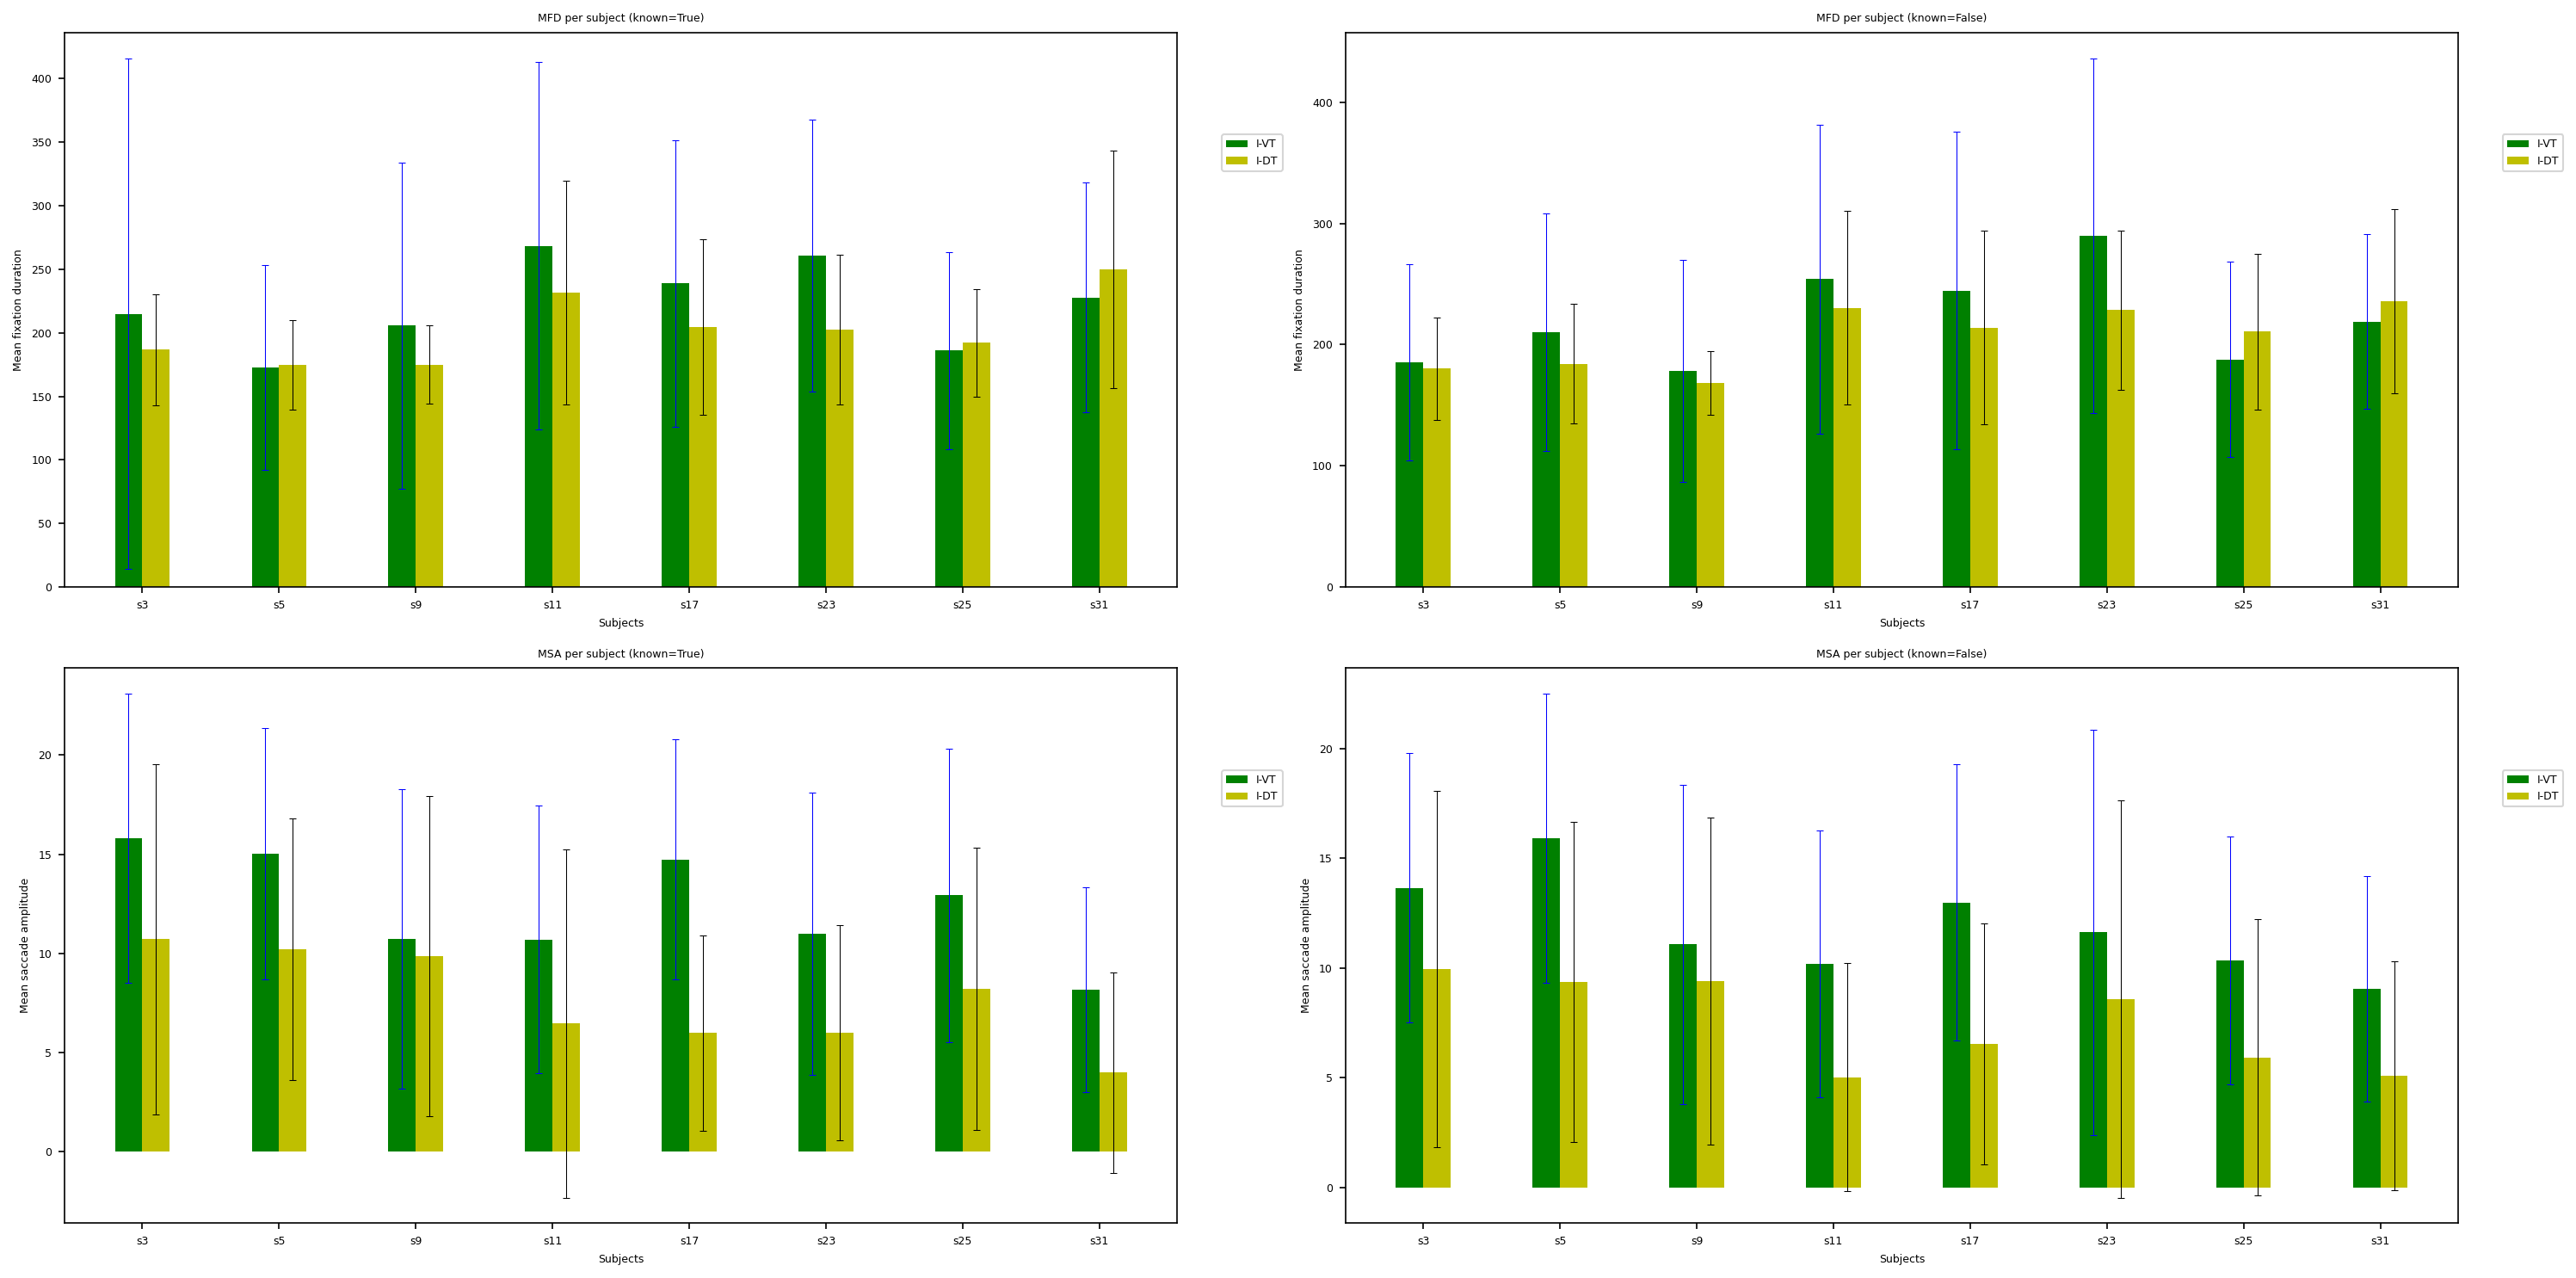

In [ ]:
figure = plt.figure()

figure, axes = plt.subplots(nrows = 2, ncols = 2)

left_bar = np.asarray(range(len(subjects)))-0.1
right_bar = np.asarray(range(len(subjects))) + 0.1

axes[0][0] = bar_chart(axes[0][0], left_bar, right_bar,
                       mfd_true_ivt, mfd_true_idt, mfd_sd_true_ivt,
                       mfd_sd_true_idt, 'MFD per subject (known=True)', 'Mean fixation duration')
axes[0][1] = bar_chart(axes[0][1], left_bar, right_bar,
                       mfd_false_ivt, mfd_false_idt, mfd_sd_false_ivt,
                       mfd_sd_false_idt, 'MFD per subject (known=False)', 'Mean fixation duration')
axes[1][0] = bar_chart(axes[1][0], left_bar, right_bar,
                       msa_true_ivt, msa_true_idt, msa_sd_true_ivt,
                       msa_sd_true_idt, 'MSA per subject (known=True)', 'Mean saccade amplitude')
axes[1][1] = bar_chart(axes[1][1], left_bar, right_bar,
                       msa_false_ivt, msa_false_idt, msa_sd_false_ivt,
                       msa_sd_false_idt, 'MSA per subject (known=False)', 'Mean saccade amplitude')

figure.tight_layout()
figure.savefig('/content/drive/MyDrive/msa_mfd_mean.eps', format='eps')

In [ ]:
print('mfd_overall_true I-VT', round(mfd_overall_true_ivt, 2), ' +/- ', round(mfd_overall_true_SD_ivt, 2))
print('mfd_overall_false I-VT', round(mfd_overall_false_ivt, 2), ' +/- ', round(mfd_overall_false_SD_ivt, 2))
print('mfd_overall_true I-DT', round(mfd_overall_true_idt, 2), ' +/- ', round(mfd_overall_true_SD_idt, 2))
print('mfd_overall_false I-DT', round(mfd_overall_false_idt, 2), ' +/- ', round(mfd_overall_false_SD_idt, 2))
print('msa_overall_true I-VT', round(msa_overall_true_ivt, 2), ' +/- ', round(msa_overall_true_SD_ivt, 2))
print('msa_overall_false I-VT', round(msa_overall_false_ivt, 2), ' +/- ', round(msa_overall_false_SD_ivt, 2))
print('msa_overall_true I-DT', round(msa_overall_true_idt, 2), ' +/- ', round(msa_overall_true_SD_idt, 2))
print('msa_overall_false I-DT', round(msa_overall_false_idt, 2), ' +/- ', round(msa_overall_false_SD_idt, 2))

mfd_overall_true I-VT 214.65  +/-  124.59
mfd_overall_false I-VT 214.9  +/-  100.48
mfd_overall_true I-DT 197.34  +/-  64.02
mfd_overall_false I-DT 202.8  +/-  65.55
msa_overall_true I-VT 12.65  +/-  7.15
msa_overall_false I-VT 11.9  +/-  6.74
msa_overall_true I-DT 8.41  +/-  7.43
msa_overall_false I-DT 8.07  +/-  7.27


In [ ]:
# Calculate U-test on mfd and msa distributions
# for known True and False for both algorithms
print('I-VT: MFD true Vs false ', mannwhitneyu(mfd_true_ivt, mfd_false_ivt))
print('I-VT: MSA true Vs false ', mannwhitneyu(msa_true_ivt, msa_false_ivt))
print('I-DT: MFD true Vs false ', mannwhitneyu(mfd_true_idt, mfd_false_idt))
print('I-DT: MSA true Vs false ', mannwhitneyu(msa_true_idt, msa_false_idt))

I-VT: MFD true Vs false  MannwhitneyuResult(statistic=31.0, pvalue=0.4790609632888714)
I-VT: MSA true Vs false  MannwhitneyuResult(statistic=29.0, pvalue=0.3964477515894803)
I-DT: MFD true Vs false  MannwhitneyuResult(statistic=29.0, pvalue=0.3964477515894803)
I-DT: MSA true Vs false  MannwhitneyuResult(statistic=28.0, pvalue=0.356595630508036)


In [ ]:
# Calculate U-test on mfd and msa
# comparing values from I-VT and I-DT
print('MFD true: I-VT Vs I-DT ', mannwhitneyu(mfd_true_ivt, mfd_true_idt))
print('MFD false: I-VT Vs I-DT ', mannwhitneyu(mfd_false_ivt, mfd_false_idt))
print('MSA true: I-VT Vs I-DT ', mannwhitneyu(msa_true_ivt, msa_true_idt))
print('MSA false: I-VT Vs I-DT ', mannwhitneyu(msa_false_ivt, msa_false_idt))

MFD true: I-VT Vs I-DT  MannwhitneyuResult(statistic=21.0, pvalue=0.13507426636425302)
MFD false: I-VT Vs I-DT  MannwhitneyuResult(statistic=25.0, pvalue=0.24741826905654868)
MSA true: I-VT Vs I-DT  MannwhitneyuResult(statistic=5.0, pvalue=0.0026924700000735156)
MSA false: I-VT Vs I-DT  MannwhitneyuResult(statistic=3.0, pvalue=0.0013808022089137366)


In [ ]:
# Calculate U-test on mfd and msa
# for I-VT and I-DT
print('I-VT true: MSA Vs MFD ', mannwhitneyu(msa_true_ivt/np.linalg.norm(msa_true_ivt),
                                             mfd_true_ivt/np.linalg.norm(mfd_true_ivt)))
print('I-VT false: MSA Vs MFD ', mannwhitneyu(msa_false_ivt/np.linalg.norm(msa_false_ivt),
                                              mfd_false_ivt/np.linalg.norm(mfd_false_ivt)))
print('I-DT true: MSA Vs MFD ', mannwhitneyu(msa_true_idt/np.linalg.norm(msa_true_idt),
                                             mfd_true_idt/np.linalg.norm(mfd_true_idt)))
print('I-DT false: MSA Vs MFD ', mannwhitneyu(msa_false_idt/np.linalg.norm(msa_false_idt),
                                              mfd_false_idt/np.linalg.norm(mfd_false_idt)))

I-VT true: MSA Vs MFD  MannwhitneyuResult(statistic=31.0, pvalue=0.4790609632888714)
I-VT false: MSA Vs MFD  MannwhitneyuResult(statistic=31.0, pvalue=0.4790609632888714)
I-DT true: MSA Vs MFD  MannwhitneyuResult(statistic=30.0, pvalue=0.4374129884746219)
I-DT false: MSA Vs MFD  MannwhitneyuResult(statistic=32.0, pvalue=0.4790609632888714)
